Summary: The most prominent trend observed is that B predicts a lot more often the positive class (>4500 bike shares) than A. The exact reasons depend on temperature: For very low temperatures (<0.24), both classifiers agree on the negative class. For very high temperatures (>0.73) and summer months, there is a high chance for differences if humidity is in the mid-range and windspeed is not too high. For medium temperatures, there is a high chance for differences unless humidity is very high or very low, month is December, January, February or May and windspeed is very high or low.

Explanations per cluster of instances with similar effects:

B predicts the positive class where A still predicts the negative class for instances with these characteristics:
- $0.24 < temp < 0.59 \land 0.24 < atemp < 0.57$ (56 instances out of 76) (Cluster 5)
  - if hum was relatively high (≥0.9), mnth was relatively low (≤2 (February)), temp was relatively low (≤0.25) and atemp was relatively low (≤0.3), both would predict the negative class
  - if mnth was 5 (May), temp was relatively high (≥0.55), hum was relatively low (≤0.3) and windspeed was relatively low (≤0.05), both would predict the positive class.
- $0.32 < temp < 0.67 \land 1 ≤ mnth ≤ 4 \land 1 ≤ season ≤ 2 \land 0.31 < atemp < 0.62$ (33 instances out of 40 total) (Cluster 4)
  - if season was relatively low (1), hum was relatively high (≥0.8), temp was relatively low (≤0.4), windspeed was relatively high (≥0.45) and weathersit was relatively high (2), both would predict the negative class
  - if season was higher (≥3 (summer)), mnth was higher (≥6 (June)) and atemp was higher (≥0.62), both would predict the positive class.
- $0.29 < temp < 0.76 \land 4 ≤ mnth \land 2 ≤ season \land 0.36 < hum \land 0.24 < atemp < 0.71$ (30 instances out of 106 total) (Cluster 2)
  - if season was lower (1) and temp was lower (≤ 0.29), both would predict the negative class
  - if windspeed was relatively low (≤0.1), hum was relatively low (≤ 0.4), and temp was relatively high (≥ 0.6), both would predict the positive class
- $0.73 < temp \land 6 ≤ mnth ≤ 9 \land 2 ≤ season ≤ 3 \land 0.44 < hum < 0.75 \land windspeed < 0.30 \land 0.70 < atemp$ (24 instances out of 27 total) (Cluster 3)
  - if mnth was February, season was winter, temp was lower (≤0.3) and atemp was lower (≤0.3), both would predict the negative class
  - if temp was relatively low (≤0.74), atemp was relatively low (≤0.7) and windspeed was relatively low (≤0.12), both would predict the positive class
- $0.47 < temp < 0.74 \land 5 ≤ mnth \land 2 ≤ season \land 0.63 < hum \land 0.46 < atemp < 0.70$ (2 instances out of 47 total) (Cluster 1)
  - if temp was lower (≤ 0.32), both would predict the negative class
  - if atemp was relatively high (≥ 0.67), both would predict the positive class

A predicts the positive class where B still predicts the negative class for instances with these characteristics:
- $0.21 < temp < 0.42 \land 10 ≤ mnth \land (season == 1 \lor season == 4) \land hum < 0.17 \land 0.22 < atemp < 0.42$ (2 instances out of 16 total) (Cluster 1)
  - if season was relatively low (1 (winter)), both would predict the negative class.
  - if temp was higher (≥0.5), both would predict the positive class.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import shap
import matplotlib.pyplot as plt
from IPython.display import display
from tasks.bike_sharing import make_task
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison
shap.initjs()

XGBoost prints many warnings, that are safe to ignore:

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()

In [4]:
try:
    with open('shap-values.pickle', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    print('Loaded state')
except FileNotFoundError:
    pass

Loaded state


# Setup Task

In [5]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

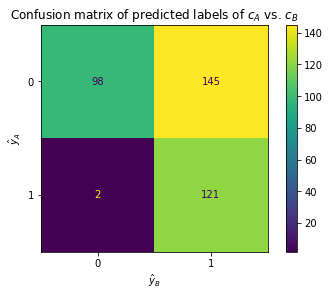

In [6]:
comparer.plot_confusion_matrix(X)

We can see already, that A predicts a lot more often less than 4500 shares than B, reflected in the high number of instances in difference class $(0,1)$. On the contrary, only two instances fall into $(1,0)$.

In [7]:
is_pred_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

In [10]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])

Exact explainer: 367it [02:11,  2.67it/s]                         
Exact explainer: 367it [01:34,  3.45it/s]                         
Exact explainer: 367it [03:50,  1.52it/s]                         

CPU times: user 26min 13s, sys: 36.1 s, total: 26min 49s
Wall time: 7min 36s


In [11]:
with open('shap-values.pickle', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite), f, pickle.HIGHEST_PROTOCOL)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

Both classifiers have the same most important feature: `temp`. Besides that, they're quite different.
`mnth`, `hum`, `atemp`, `weekday`, `workingday` are of bigger importance to A than to B.
`mnth` is also the feature with the biggest difference of feature importance.
`season`, `weathersit` are of higher importance to B than to A.
Finally, `holiday` has no significant importance to either classifiers.
Therefore I will omit it from further explanations.

Based on this, I can speculate about the following theories:
- Both classifiers are influenced by time of the year: A more by month, B more by season
- Both classifiers are influenced by weather conditions: A more by temperature and humidity, B more by weathersituation
- holiday is not used to make decisions, because workingday is already sufficient
- B depends less on weekday and workingday, possibly indicating a shift of habits

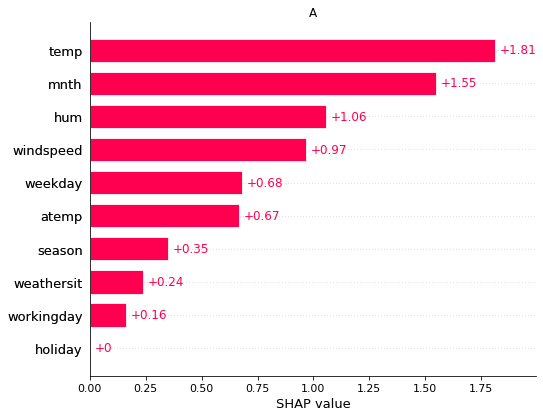

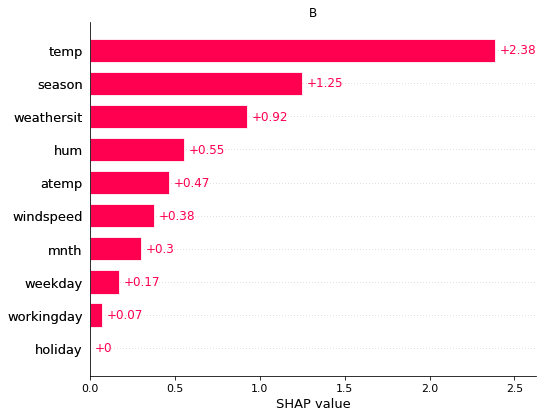

In [25]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [26]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds[:, :, 1])

In [27]:
feature_order = feature_order[:9]

In [28]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects(explanations.indiv.log_odds[:, [feature_idx], 1], color=is_pred_diff)
it = iter(feature_order)

In the SHAP summary plot we can see, that the most important feature `temp`
generally indicates an increase in log odds for high values
and a decrease in log odds for low values.
But the distribution is different:
For A, low feature values indicate a very specific decrease of log odds.
On the contrary, there is a wide range of different SHAP values for B.
This indicates, that there are many different ways low temperature values influences the prediction in B,
but only a few in A.

For A, we can see a stepped effect from low to high feature values with the step at 0.5,
which gradually decreases again at 0.7.
For B, the effect of `temp` gradually increases, starting from 0.3 until it reaches its maximum at 0.5.

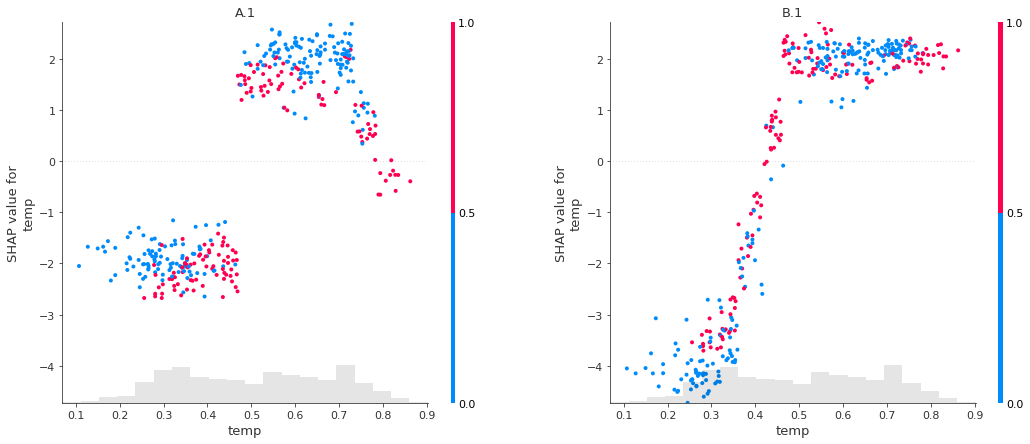

In [29]:
plot_next_feature()

As previously noted in the feature importance section, `mnth` is much more important
to A than to B. Higher feature values increase the log odds prediction to a varying extent in A,
whereas in B they nearly have no influence. Lower feature values decrease the log odds prediction
in A, but there are instances in B where they either increase or decrease the log odds prediction.

According to the feature effects plots, the first four months have a negative effect while the
higher months have a positive effect on the outcome of A.
For B, only the first two months have a negative effect and especially month 3 has a positive effect.

Similarly to the effects plots of `temp`, we see
a vertical separation of instances classified differently and equally, which means,
interaction effects are present.

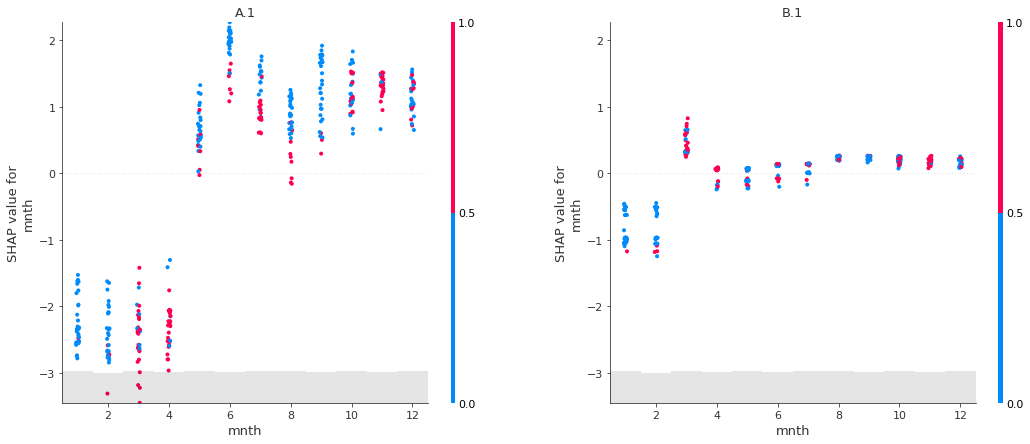

In [30]:
plot_next_feature()

For both classifiers, high `hum` values decrease the log odds outcome to a similar extent.
But the lower values are different. In B, they flat out between 0.5 and 1, but in A,
they continue to increase for lower values. This means, that in B, there are not many ways
how low values of `hum` can influence the outcome, but there are many for A.

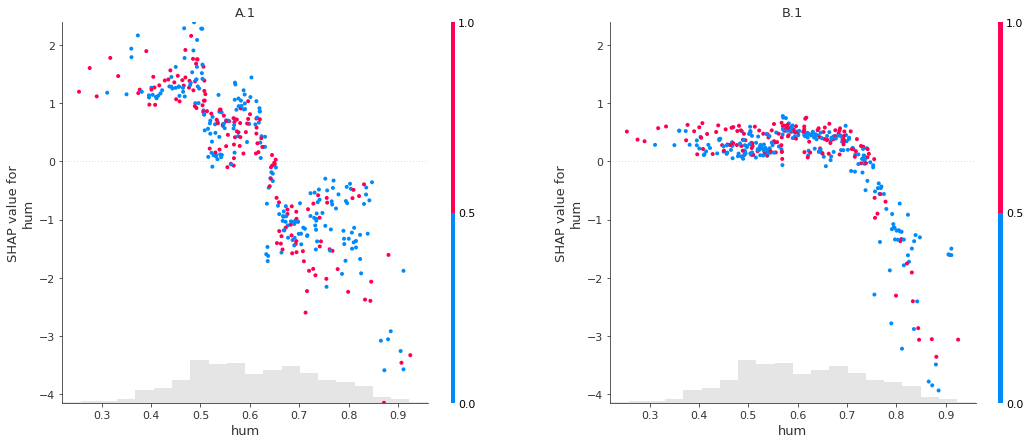

In [31]:
plot_next_feature()

`season` 1 (winter) has much bigger negative influence on model B than on A, with a broader
range of values. To instances classified differently in this group the effect is smaller,
originating from interaction effects with other features.
The other seasons have higher increasing effect to B than A.

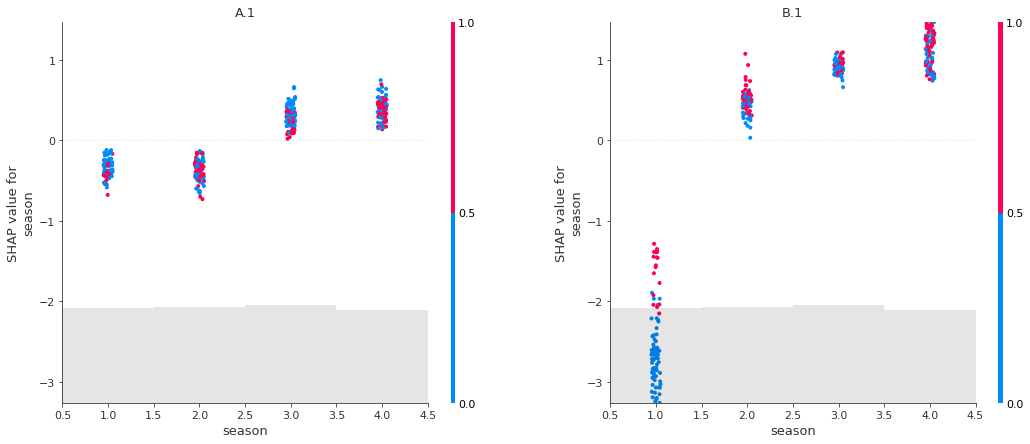

In [32]:
plot_next_feature()

Windspeed has higher and more pronounced influence on model A than B, with low feature
values increasing and high feature values decreasing the outcome.

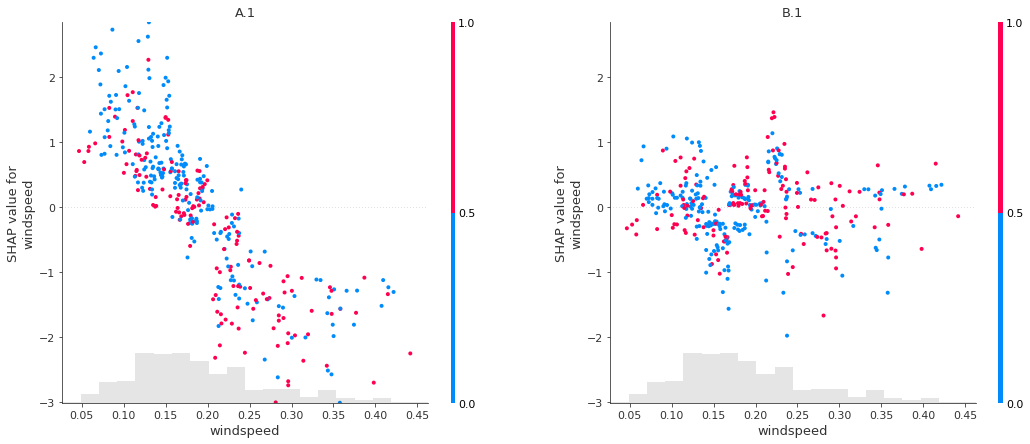

In [33]:
plot_next_feature()

For B, high values of `weathersit` (snow and rain) have bigger negative influence and low values
(clear to mist) have bigger positive influence than for A. It is possibly a better predictor
in the newer model than `windspeed` and `hum` combined.

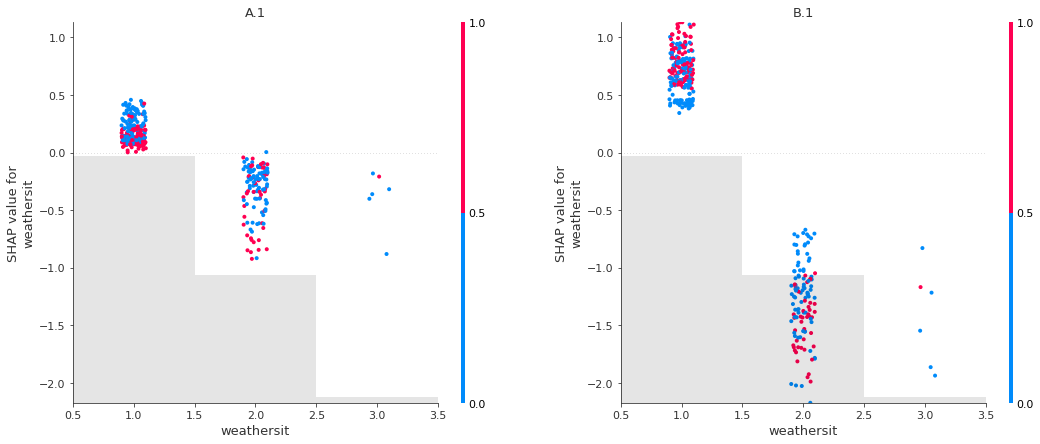

In [34]:
plot_next_feature()

High feature values of `atemp` influence the models differently:
For A, it has quite diverse effects ranging from -3 to +2, whereas for B,
it just indicates a small positive influence.

The effects look similar, except for values above 0.7,
where all instances are classified differently.
Here we observe a negative influence on A but positive influence on B.

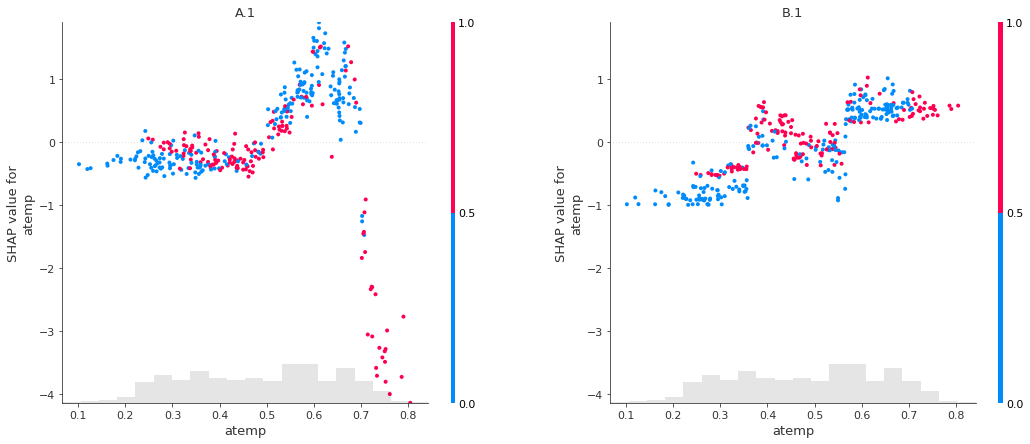

In [35]:
plot_next_feature()

Even though the influences of `weekday` on model B are small and decreasing from low (Sunday)
to high (Saturday) values,
they are the opposite of those on model A.

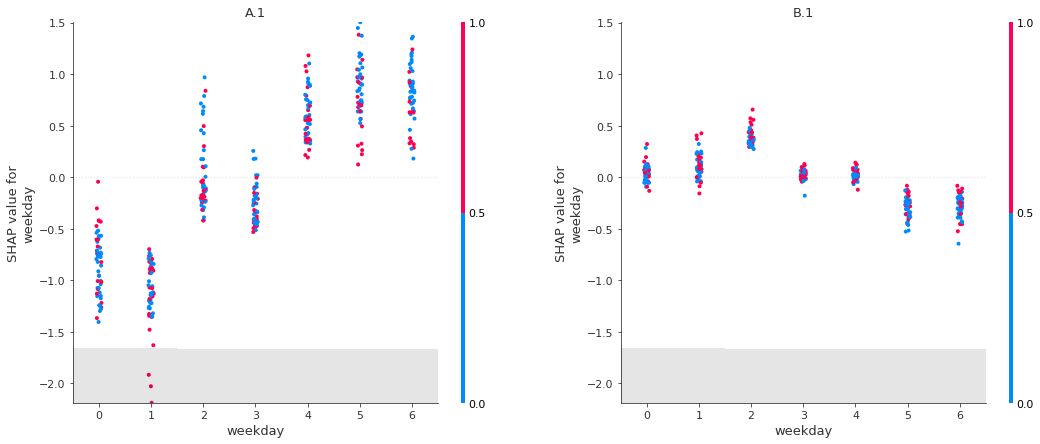

In [36]:
plot_next_feature()

`workingday` is considered more important by A, which also shows a clearer separation
of low and high values, low values (weekend or holiday) having positive influence on the outcome.
To B, it seems to be random noise with no special influence of low or high values,
and no characteristics of instances classified differently.
I assume that model A differentiates
more between work and leisure time, with more people using bicycles in their leisure time
and/or in the second half of the week, reasons not present in model B.

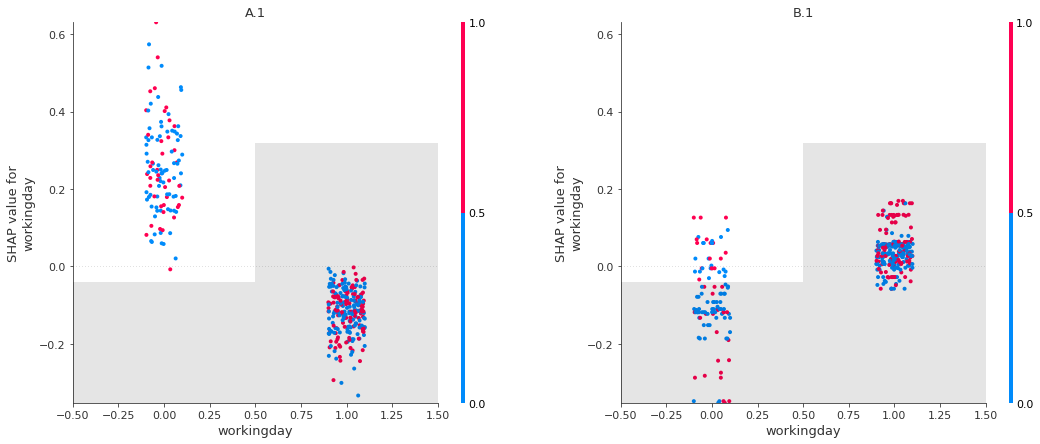

In [37]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

In the figure below we can see the feature importances per class.
`temp` is the most important feature overall. `holiday` has zero importance, so I will not analyze its effects.

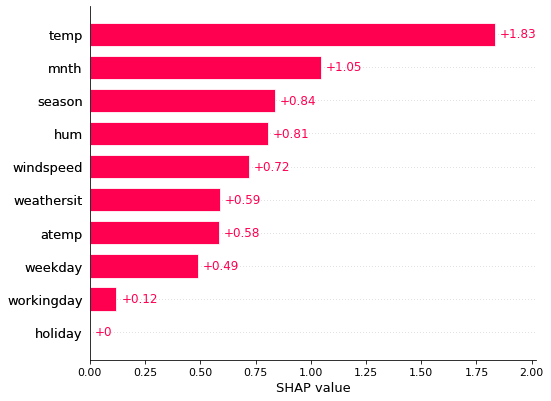

In [38]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [39]:
global_feature_order = feature_order
feature_order = feature_order[:-1]

In [40]:
global_data = pd.DataFrame(X, columns=explanations.feature_names)
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [42]:
global_data['workingday'].value_counts()

1.0    250
0.0    116
Name: workingday, dtype: int64

In [43]:
global_data['weathersit'].value_counts()

1.0    237
2.0    123
3.0      6
Name: weathersit, dtype: int64

Considering that there are only four classes and all have importance, I will stick to the original ordering.

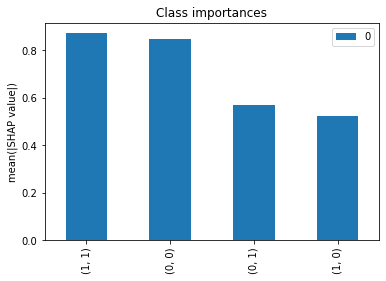

In [44]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [45]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx]], color=is_pred_diff)
it = iter(feature_order)

For instances with low feature values ($temp<0.3$), this feature increases the outcome for class $(0,0)$ extremely,
for most of them by more than 4. Until 0.5, there is a drop in log odds of this class
and first an increase of $(1,0)$, then an even higher increase of $(0,1)$.
Many instances classified differently fall into this range.
Above 0.5, there is a sudden increase of $(1,1)$, which gets lower
at 0.7 while getting higher for $(0,1)$ again, also containing
many instances classified differently.

Even though this is the feature of highest importance for the differences,
its explanation does not cover all instances. Especially for those with
$0.5<temp<0.7$, this feature cannot be the reason for them being classified
differently.

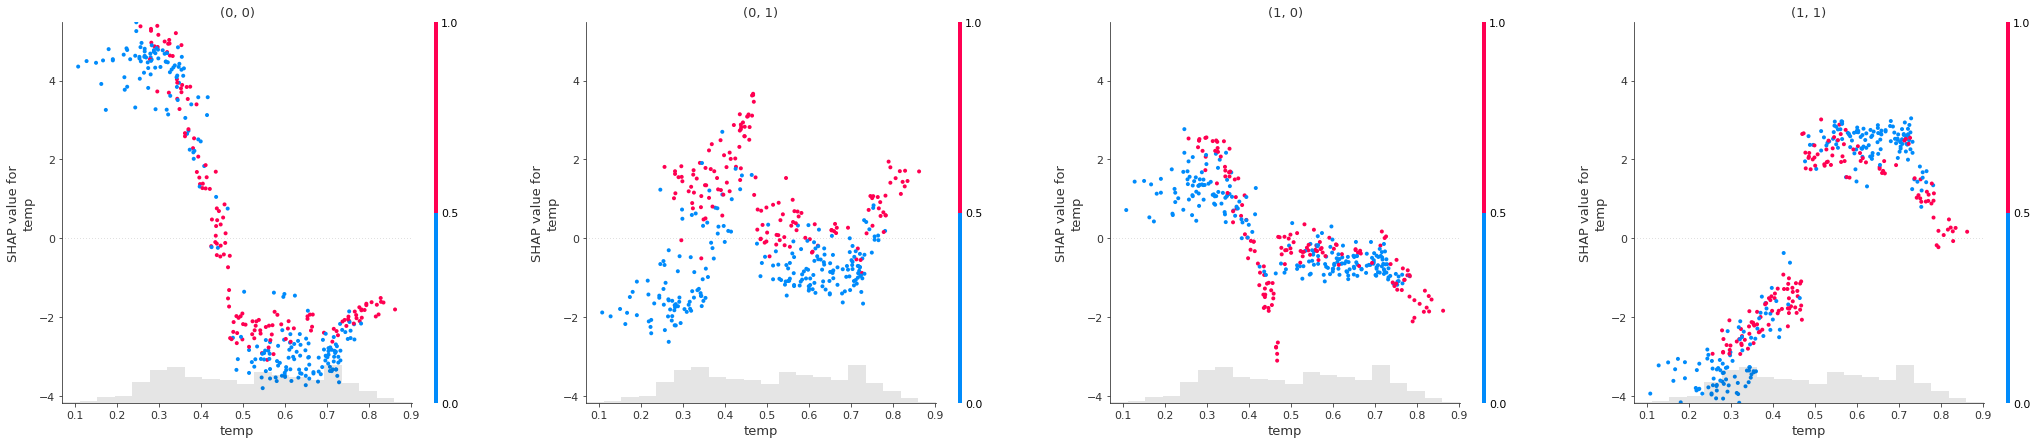

In [46]:
plot_next_feature()

Starting with the first two values of `mnth`, this feature has an increasing effect on the outcome of $(0,0)$,
with nearly no instances classified differently.
For months 3 and 4 it primarily increases the odds of $(0,1)$.
Continuing with higher values, it increases the odds to a varying degree of $(1,1)$ and $(1,0)$ to a lower extent.

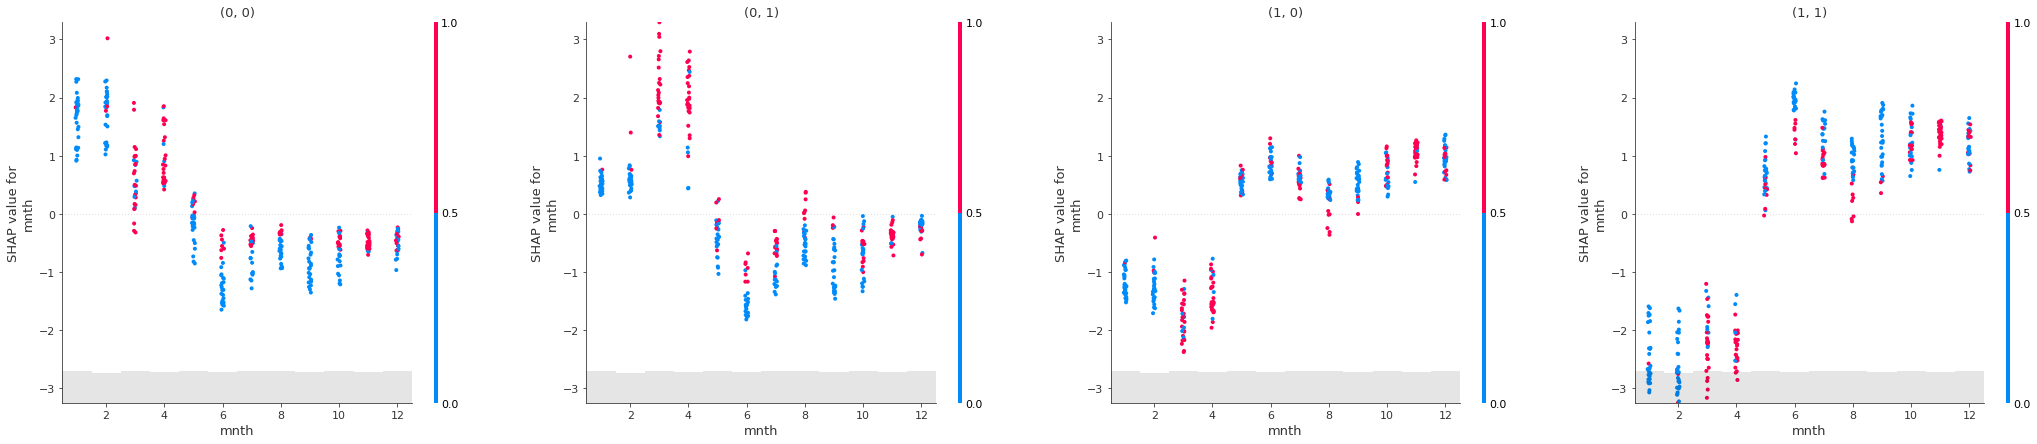

In [47]:
plot_next_feature()

For instances with low `season` values (winter) the feature has an increasing effect on the odds of $(0,0)$,
and to a lower extent of $(1,0)$. But for those that are classified differently the increasing effect
is on the lower side and the decreasing effect on $(0,1)$ is smaller too, suggesting interaction effects
with other features. For instances of spring,
summer and fall the feature has a low increasing effect on the odds of $(1,1)$ and $(0,1)$.

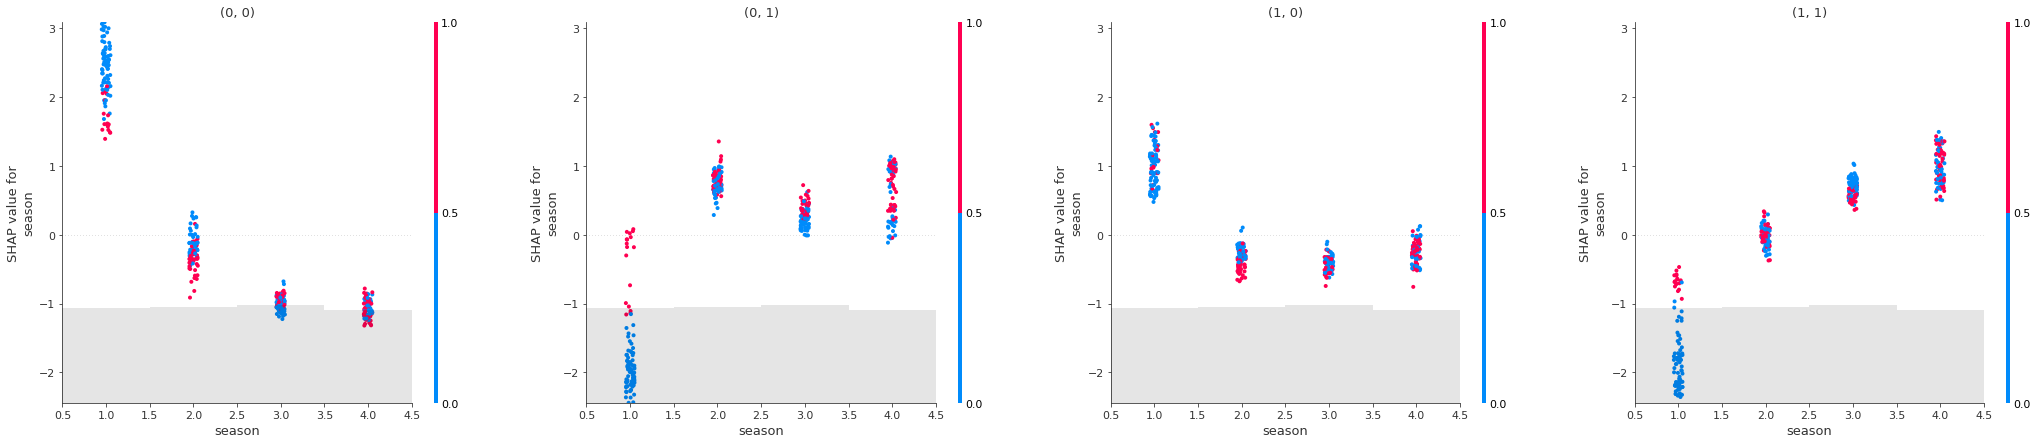

In [48]:
plot_next_feature()

Generally, for this feature there is positive correlation
with its increase in outcome of $(0,0)$ and negative correlation with its
increase in outcome of $(1,1)$.

Nevertheless, for instances with values around 0.7 there is a slight increase
in the outcome of $(0,1)$ and for instances with values below 0.5 and above
0.75 there is a slight increase in the outcome of $(1,0)$.

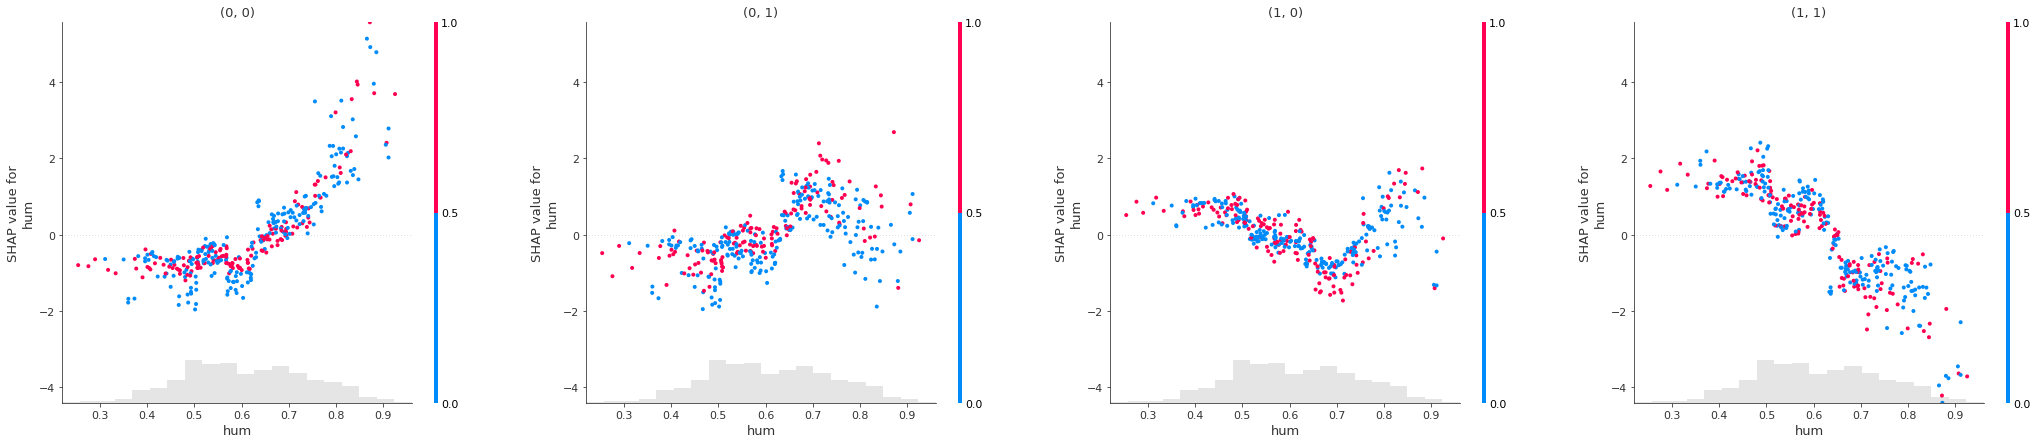

In [49]:
plot_next_feature()

For `windspeed`, there is a positive correlation with the effect on $(0,0)$ and $(0,1)$,
and a negative correlation with the effect on $(1,1)$ and $(1,0)$ to a lower extent.

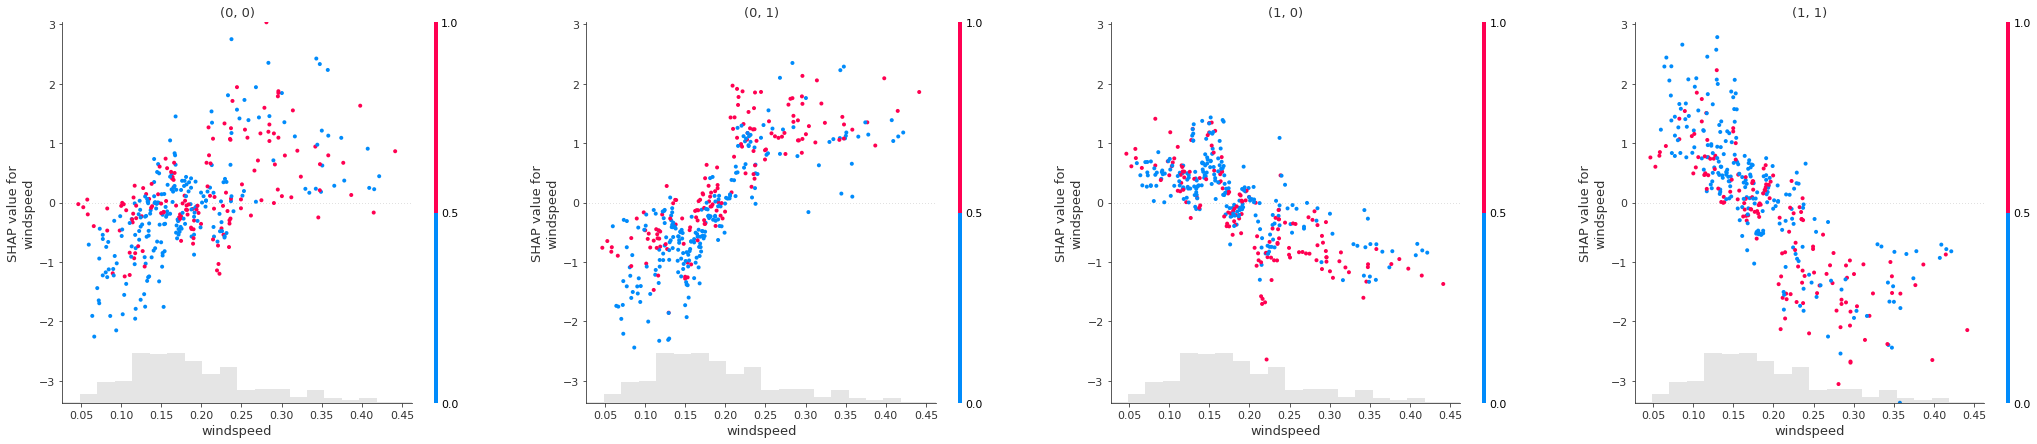

In [50]:
plot_next_feature()

For instances with `weathersit` 1 (clear) the feature has a slightly 
increasing effect on $(1,1)$. For instances with values 2 or 3 (bad weather
conditions) it has an increasing effect on $(0,0)$ and to a lower extent
on $(1,0)$.

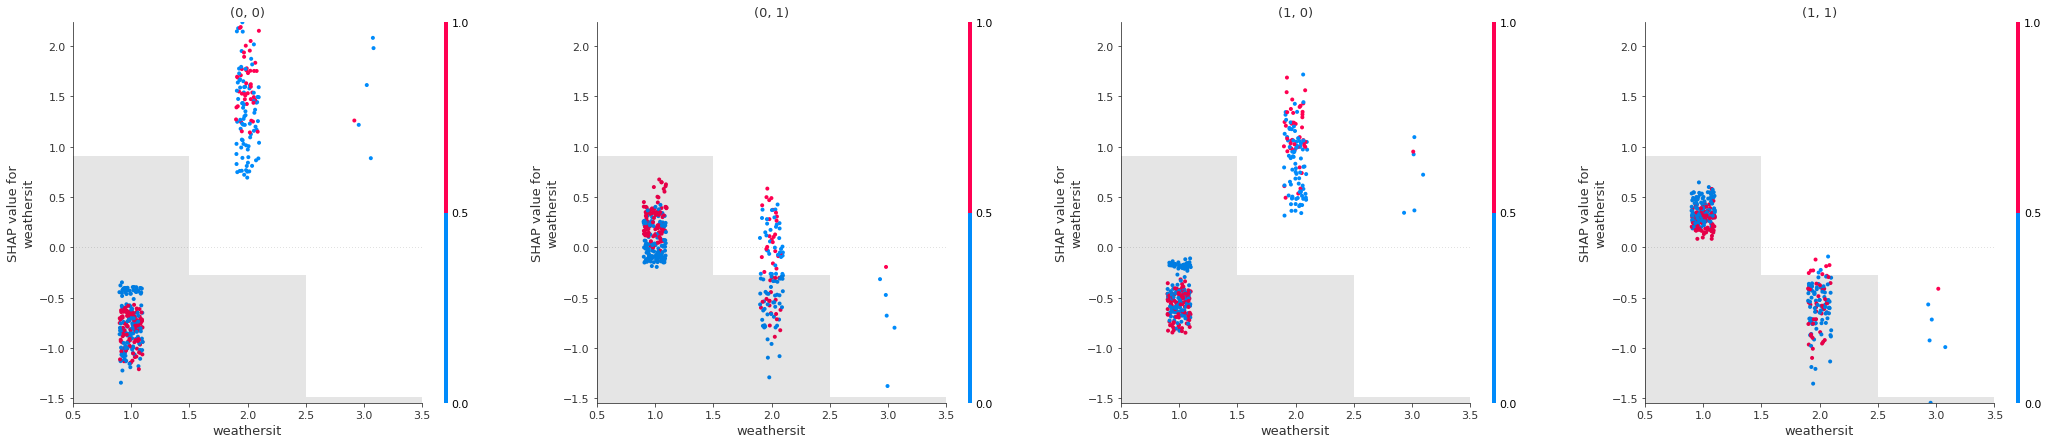

In [51]:
plot_next_feature()

For instances with low `atemp` values this feature has a slightly increasing
effect on $(0,0)$. Up to 0.5, its effect decreases while the effect on $(0,1)$
increases slightly. Up to 0.7, the effect on $(0,1)$ decreases again
but increases on $(1,1)$, with fewer instances classified differently in this range.
Above, the effect on $(1,1)$ drops to negative values while it increases
dramatically on $(0,1)$, where all instances are classified differently.
`atemp` is probably the main reason for them being classified differently.

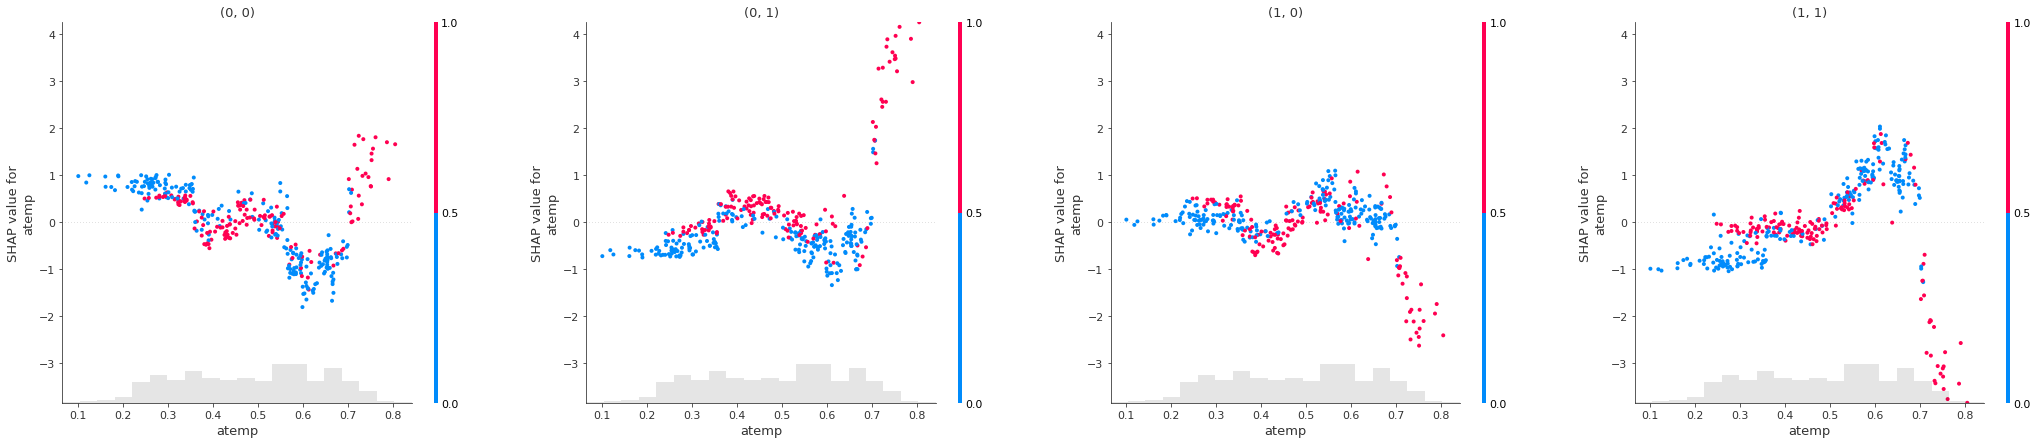

In [52]:
plot_next_feature()

For instances with low `weekday` values (Sunday and Monday) the feature has an increasing effect
on the odds of $(0,1)$ and to a lower extent of $(0,0)$,
while for those with high feature values (Friday, Saturday and Sunday) it has an increasing effect for the odds
of $(1,0)$ and $(1,1)$.

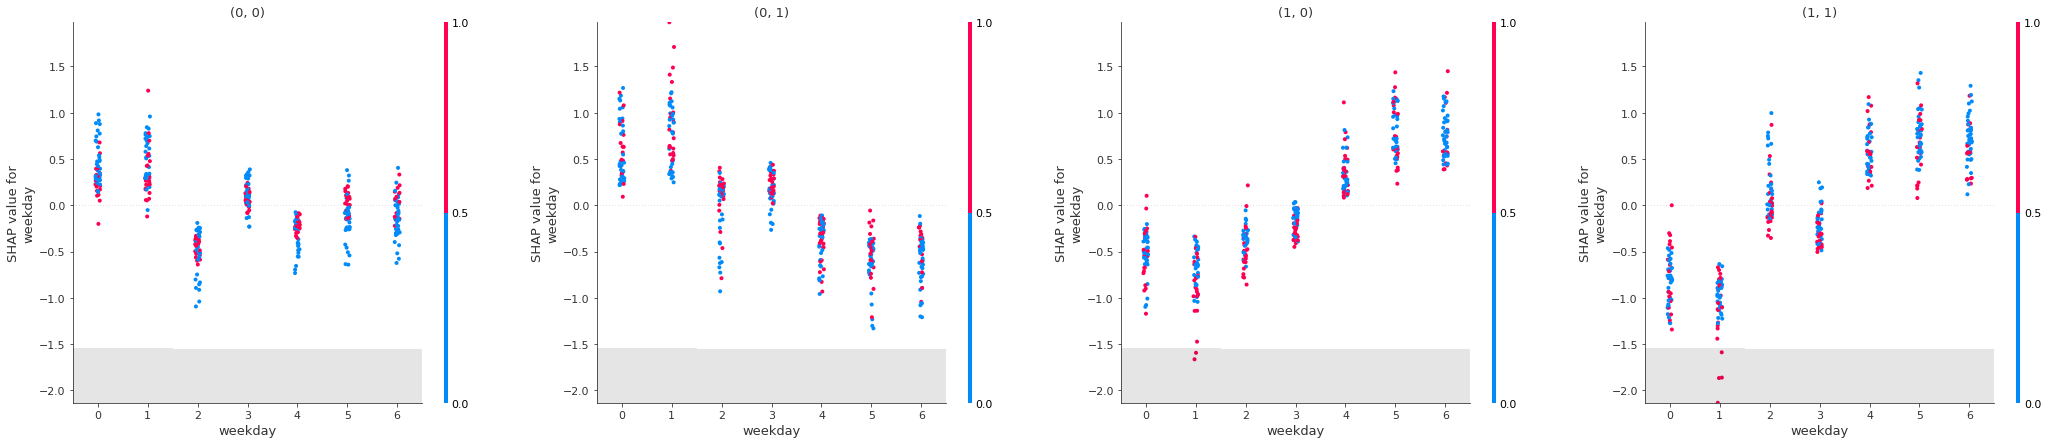

In [53]:
plot_next_feature()

For workingday we can see only a slight linear effect with big variance that tends towards $(1,0)$ and $(1,1)$ for value 0, and towards $(0,0)$ and $(0,1)$ for value 1.

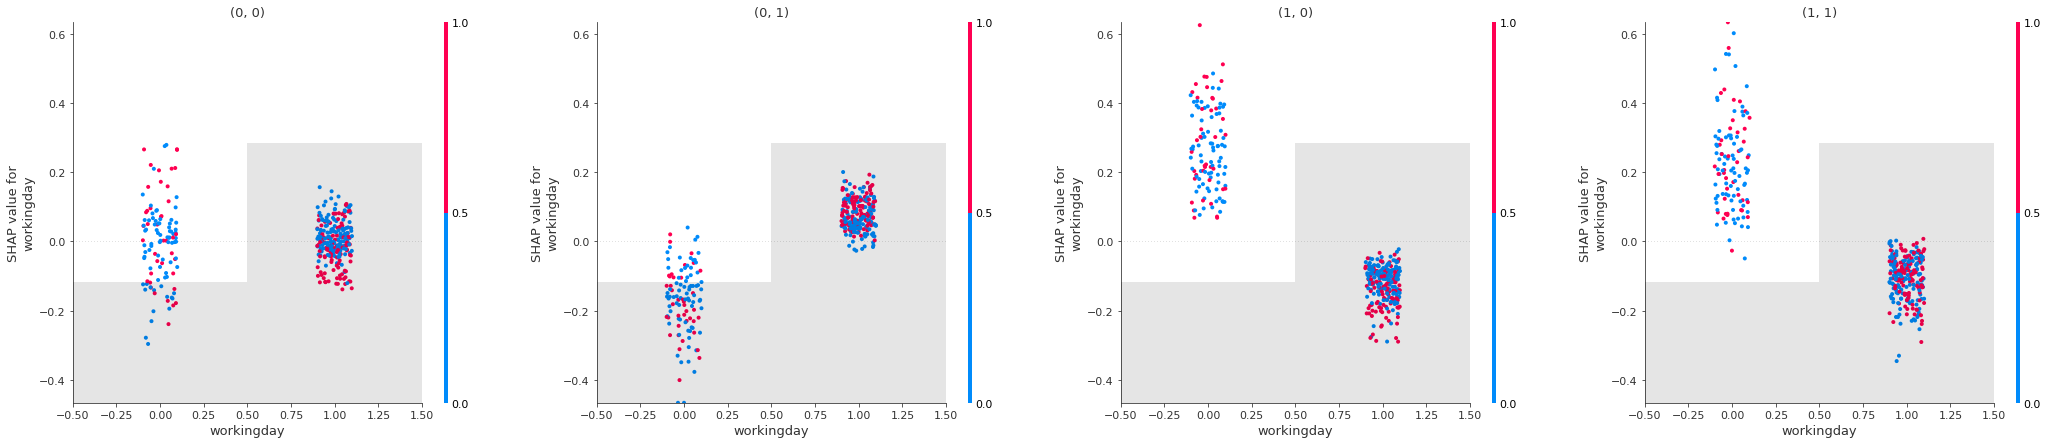

In [54]:
plot_next_feature()

# Local Explanations

In [55]:
pred_classes = comparer.class_names[mclass_diff]

In [56]:
def plot_feature(feature):
    plot_feature_effects(shap_values[:, [feature]][:, :, np.unique(pred_classes)], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}', constrained_layout=True)

In [57]:
def go_down(node, parent_nodes, traversed_nodes):
    parent_nodes.append(node)
    node = node.get_left()
    return select_node(node, parent_nodes)
    
def select_node(node, parent_nodes):
    explanations_cluster = explanations[node.pre_order()]
    shap_values = explanations_cluster.mclass_diff.log_odds
    pred_classes = comparer.predict_mclass_diff(explanations_cluster.data)
    pred_classes = comparer.class_names[pred_classes]
    classes = np.unique(pred_classes)
    print(f'Level {len(parent_nodes)}')
    print(pd.Series(pred_classes).value_counts())
    return node, shap_values, pred_classes

def get_next(node, parent_nodes, traversed_nodes):
    traversed_nodes.append(node)
    node = parent_nodes.pop()
    if node.get_right() in traversed_nodes:
        return get_next(node, parent_nodes, traversed_nodes)
    parent_nodes.append(node)
    node = node.get_right()
    return select_node(node, parent_nodes)

## Clustering of Class $(0,1)$ SHAP Values

In [224]:
diff_class = '(0, 1)'
shap_values = explanations.mclass_diff.log_odds[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

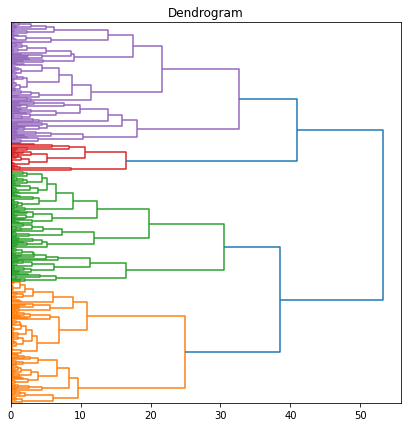

In [225]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [226]:
root = sp.cluster.hierarchy.to_tree(Z)
node = root
parent_nodes = []
traversed_nodes = []

### Cluster 1

In [227]:
node, shap_values, pred_classes = go_down(node, parent_nodes, traversed_nodes)

Level 1
(1, 1)    115
(0, 0)     76
(0, 1)     32
dtype: int64


In [62]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [63]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.513021,6.219731,2.313901,0.625372,0.190011,1.399103,0.485481,2.914798,0.677130,0.031390
std,0.182953,3.355937,1.082263,0.126759,0.076985,0.526247,0.163964,2.015013,0.468625,0.174762
min,0.107500,1.000000,1.000000,0.311250,0.064071,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.326250,3.000000,1.000000,0.528125,0.135585,1.000000,0.324802,1.000000,0.000000,0.000000
50%,0.568333,6.000000,2.000000,0.633333,0.175996,1.000000,0.544842,3.000000,1.000000,0.000000
75%,0.663750,9.000000,3.000000,0.725625,0.229279,2.000000,0.615548,5.000000,1.000000,0.000000
max,0.765000,12.000000,4.000000,0.911250,0.421642,3.000000,0.706450,6.000000,1.000000,1.000000


In [64]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000
mean,0.572917,8.031250,3.031250,0.701471,0.239627,1.687500,0.543249,2.37500,0.656250,0.062500
std,0.125615,2.416134,0.860771,0.084015,0.060346,0.535061,0.112431,1.91345,0.482559,0.245935
min,0.295833,5.000000,2.000000,0.530417,0.104475,1.000000,0.274621,0.00000,0.000000,0.000000
25%,0.517709,5.750000,2.000000,0.662084,0.209423,1.000000,0.504099,1.00000,0.000000,0.000000
50%,0.578334,8.000000,3.000000,0.694375,0.233207,2.000000,0.548933,2.00000,1.000000,0.000000
75%,0.662709,10.000000,4.000000,0.742292,0.284678,2.000000,0.614443,3.25000,1.000000,0.000000
max,0.750833,12.000000,4.000000,0.871667,0.398008,3.000000,0.706450,6.00000,1.000000,1.000000


#### Going Down

In [228]:
node, shap_values, pred_classes = go_down(node, parent_nodes, traversed_nodes)

Level 2
(0, 0)    70
(1, 1)    45
(0, 1)     2
dtype: int64


In [66]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [67]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.425382,5.034188,1.786325,0.639302,0.180130,1.478632,0.408546,2.854701,0.717949,0.042735
std,0.191408,3.890598,1.065356,0.137553,0.081899,0.550835,0.173132,1.917546,0.451934,0.203129
min,0.107500,1.000000,1.000000,0.311250,0.064071,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.265833,2.000000,1.000000,0.522500,0.129987,1.000000,0.262625,1.000000,0.000000,0.000000
50%,0.344348,3.000000,1.000000,0.672500,0.161071,1.000000,0.351629,3.000000,1.000000,0.000000
75%,0.627500,9.000000,3.000000,0.736250,0.205229,2.000000,0.590917,5.000000,1.000000,0.000000
max,0.735833,12.000000,4.000000,0.911250,0.421642,3.000000,0.697621,6.000000,1.000000,1.000000


In [68]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.0
mean,0.602083,7.500000,3.000000,0.765625,0.130285,2.500000,0.559677,2.0,1.0,0.0
std,0.015910,3.535534,1.414214,0.149966,0.036502,0.707107,0.024528,0.0,0.0,0.0
min,0.590833,5.000000,2.000000,0.659583,0.104475,2.000000,0.542333,2.0,1.0,0.0
25%,0.596458,6.250000,2.500000,0.712604,0.117380,2.250000,0.551005,2.0,1.0,0.0
50%,0.602083,7.500000,3.000000,0.765625,0.130285,2.500000,0.559677,2.0,1.0,0.0
75%,0.607708,8.750000,3.500000,0.818646,0.143191,2.750000,0.568349,2.0,1.0,0.0
max,0.613333,10.000000,4.000000,0.871667,0.156096,3.000000,0.577021,2.0,1.0,0.0


#### Going Down

In [229]:
node, shap_values, pred_classes = go_down(node, parent_nodes, traversed_nodes)

Level 3
(1, 1)    45
(0, 1)     2
dtype: int64


In [70]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [71]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.645035,7.702128,2.957447,0.722473,0.129663,1.510638,0.605416,2.893617,0.851064,0.021277
std,0.060464,1.932726,0.721033,0.058319,0.033184,0.546624,0.050771,1.644940,0.359875,0.145865
min,0.475833,5.000000,2.000000,0.633333,0.064071,1.000000,0.469054,0.000000,0.000000,0.000000
25%,0.612084,5.500000,2.000000,0.675416,0.104169,1.000000,0.576712,2.000000,1.000000,0.000000
50%,0.650000,8.000000,3.000000,0.716667,0.134954,1.000000,0.603554,3.000000,1.000000,0.000000
75%,0.696667,9.000000,3.000000,0.764166,0.151739,2.000000,0.652480,4.000000,1.000000,0.000000
max,0.735833,12.000000,4.000000,0.871667,0.198992,3.000000,0.697621,6.000000,1.000000,1.000000


In [72]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.0
mean,0.602083,7.500000,3.000000,0.765625,0.130285,2.500000,0.559677,2.0,1.0,0.0
std,0.015910,3.535534,1.414214,0.149966,0.036502,0.707107,0.024528,0.0,0.0,0.0
min,0.590833,5.000000,2.000000,0.659583,0.104475,2.000000,0.542333,2.0,1.0,0.0
25%,0.596458,6.250000,2.500000,0.712604,0.117380,2.250000,0.551005,2.0,1.0,0.0
50%,0.602083,7.500000,3.000000,0.765625,0.130285,2.500000,0.559677,2.0,1.0,0.0
75%,0.607708,8.750000,3.500000,0.818646,0.143191,2.750000,0.568349,2.0,1.0,0.0
max,0.613333,10.000000,4.000000,0.871667,0.156096,3.000000,0.577021,2.0,1.0,0.0


- $0.47 < temp < 0.74$
- $5 ≤ mnth$
- $2 ≤ season$
- $0.63 < hum$
- $0.46 < atemp < 0.70$

In [73]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.32
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,2.0
"(0, 1)",2.0,NaN


Differences observed for:
- $0.32 < temp$

B starts to predict the positive class already for $temp>0.32$ for all 2 cases.

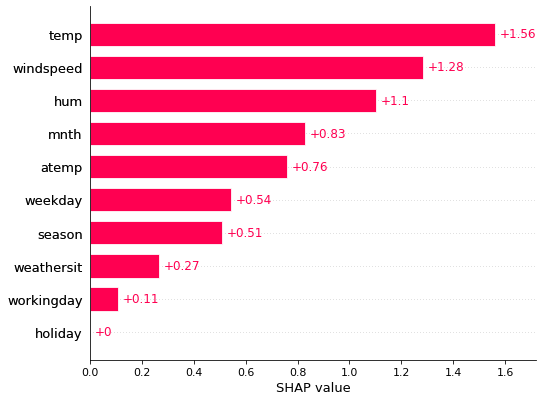

In [75]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, np.unique(pred_classes)])
plot_feature_importance_bar(feature_importances)

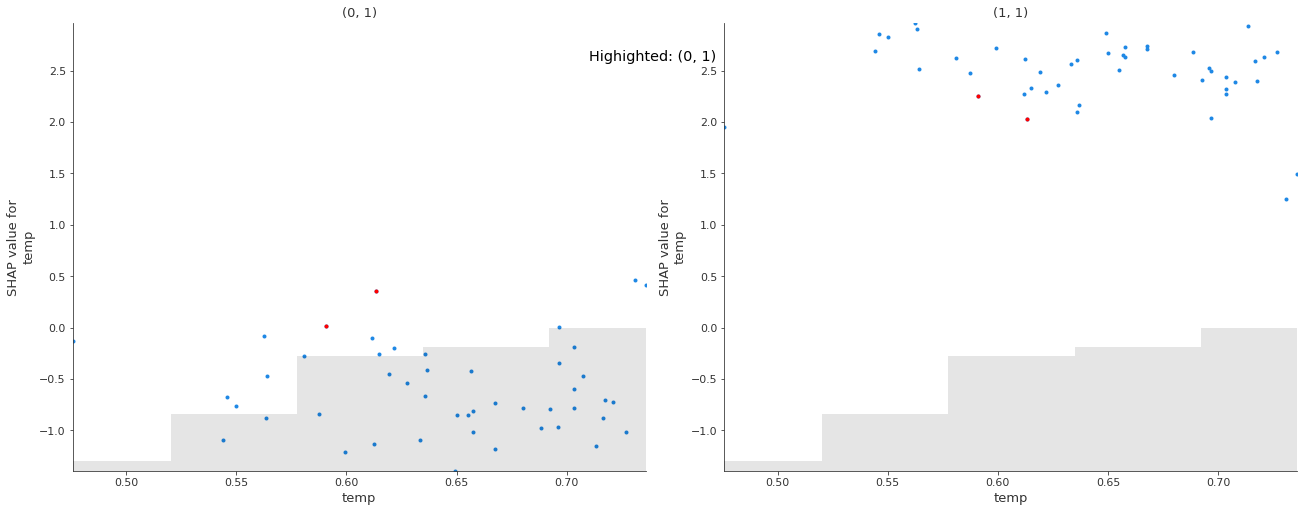

In [76]:
plot_feature('temp')

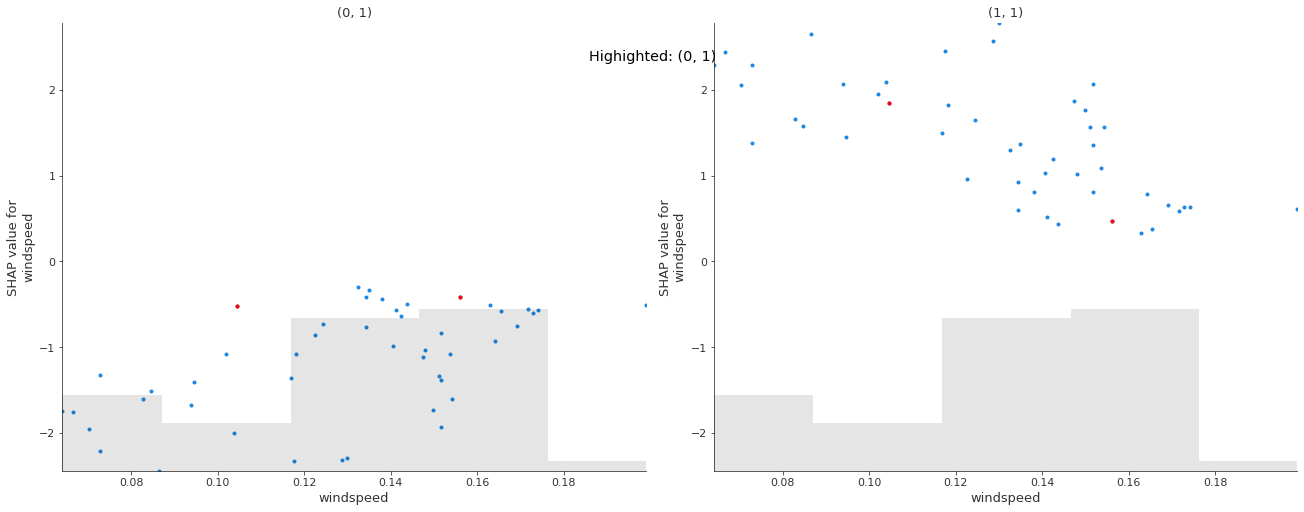

In [77]:
plot_feature('windspeed')

In [78]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['windspeed'] = X_test['windspeed'].min()
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",2.0,1
"(1, 1)",NaN,1


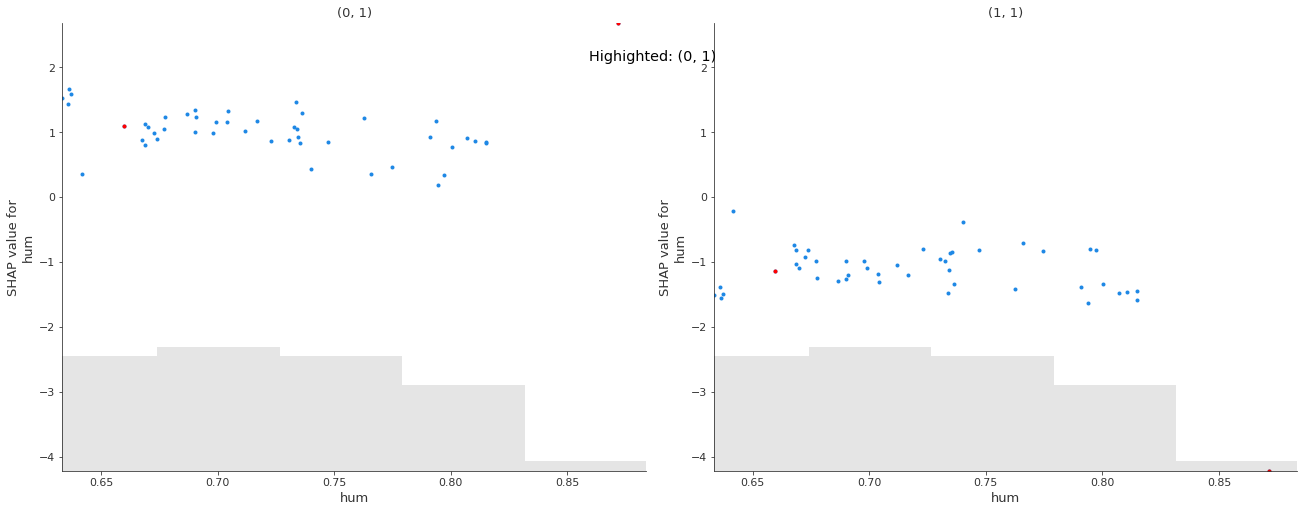

In [79]:
plot_feature('hum')

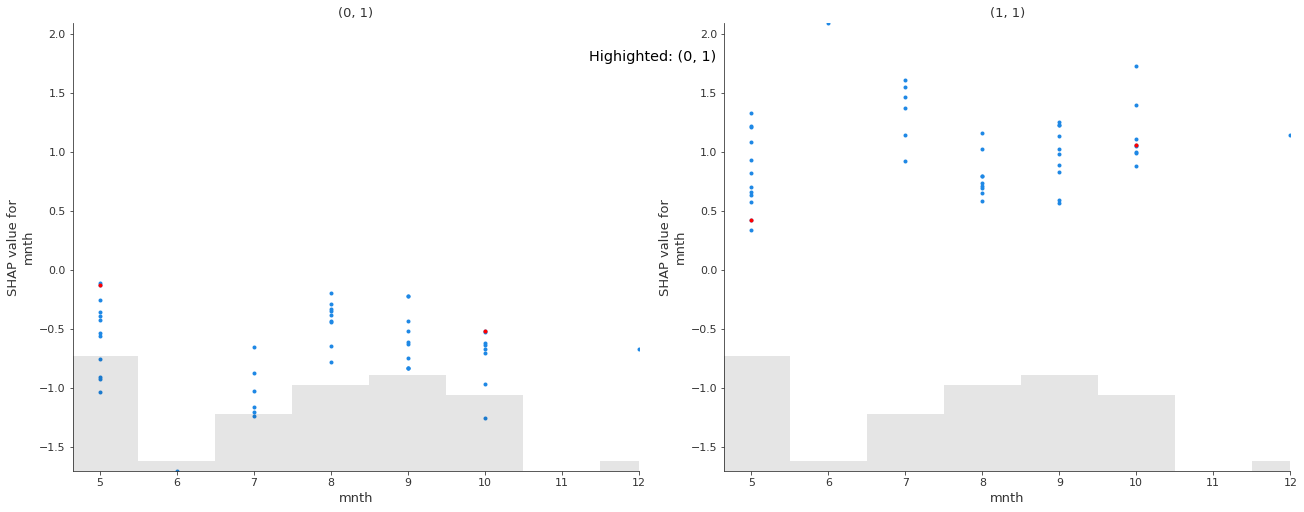

In [80]:
plot_feature('mnth')

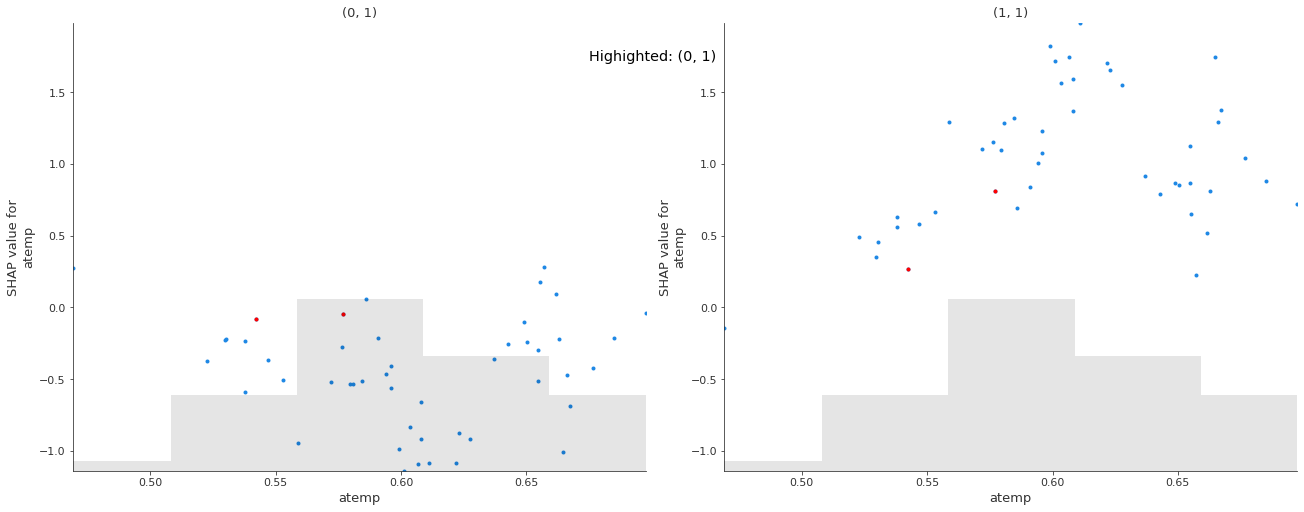

In [81]:
plot_feature('atemp')

In [82]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.67
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",2.0,NaN
"(1, 1)",NaN,2.0


Differences observed within cluster for:
- $atemp < 0.67$

A concludes with B on the positive class for atemp from 0.67 upwards in all 2 cases.

### Cluster 2

In [230]:
node, shap_values, pred_classes = get_next(node, parent_nodes, traversed_nodes)

Level 3
(0, 0)    70
dtype: int64


In [231]:
node, shap_values, pred_classes = get_next(node, parent_nodes, traversed_nodes)

Level 2
(1, 1)    70
(0, 1)    30
(0, 0)     6
dtype: int64


In [85]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [86]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.609755,7.528302,2.896226,0.609996,0.200918,1.311321,0.570400,2.981132,0.632075,0.018868
std,0.110857,1.947930,0.755037,0.112313,0.069941,0.485273,0.099249,2.124600,0.484532,0.136705
min,0.291667,4.000000,2.000000,0.360000,0.072146,1.000000,0.242400,0.000000,0.000000,0.000000
25%,0.550625,6.000000,2.000000,0.531459,0.145837,1.000000,0.533454,1.000000,0.000000,0.000000
50%,0.617916,7.500000,3.000000,0.597708,0.207096,1.000000,0.582077,3.000000,1.000000,0.000000
75%,0.706667,9.000000,3.000000,0.685520,0.237563,2.000000,0.648050,5.000000,1.000000,0.000000
max,0.765000,12.000000,4.000000,0.872500,0.398008,3.000000,0.706450,6.000000,1.000000,1.000000


In [87]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.570972,8.066667,3.033333,0.697195,0.246916,1.633333,0.542154,2.400000,0.633333,0.066667
std,0.129599,2.405931,0.850287,0.080418,0.054473,0.490133,0.116068,1.975715,0.490133,0.253708
min,0.295833,5.000000,2.000000,0.530417,0.138683,1.000000,0.274621,0.000000,0.000000,0.000000
25%,0.509791,6.000000,2.000000,0.663229,0.212227,1.000000,0.495888,1.000000,0.000000,0.000000
50%,0.571666,8.000000,3.000000,0.694375,0.236007,2.000000,0.548933,2.000000,1.000000,0.000000
75%,0.664791,10.000000,4.000000,0.739479,0.291826,2.000000,0.617278,3.750000,1.000000,0.000000
max,0.750833,12.000000,4.000000,0.845833,0.398008,2.000000,0.706450,6.000000,1.000000,1.000000


Cluster characteristics:
- $0.29 < temp < 0.76$
- $4 ≤ mnth$
- $2 ≤ season$
- $0.36 < hum$
- $0.24 < atemp < 0.71$

B starts to predict the positive class where A still predicts the negative class above season 1 and above temp 0.29 in all 30 cases.

In [88]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.29
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,8
"(0, 1)",30.0,22


In [89]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,2
"(0, 1)",30.0,28


In [90]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['season'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,6
"(0, 1)",30.0,24


In [91]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['season'] = 1
X_test['temp'] = 0.29
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,30.0
"(0, 1)",30.0,NaN


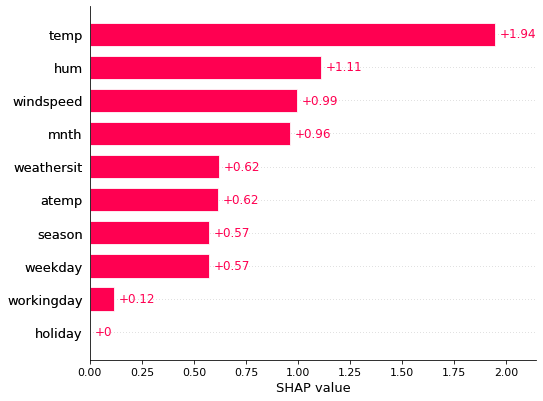

In [92]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, np.unique(pred_classes)])
plot_feature_importance_bar(feature_importances)

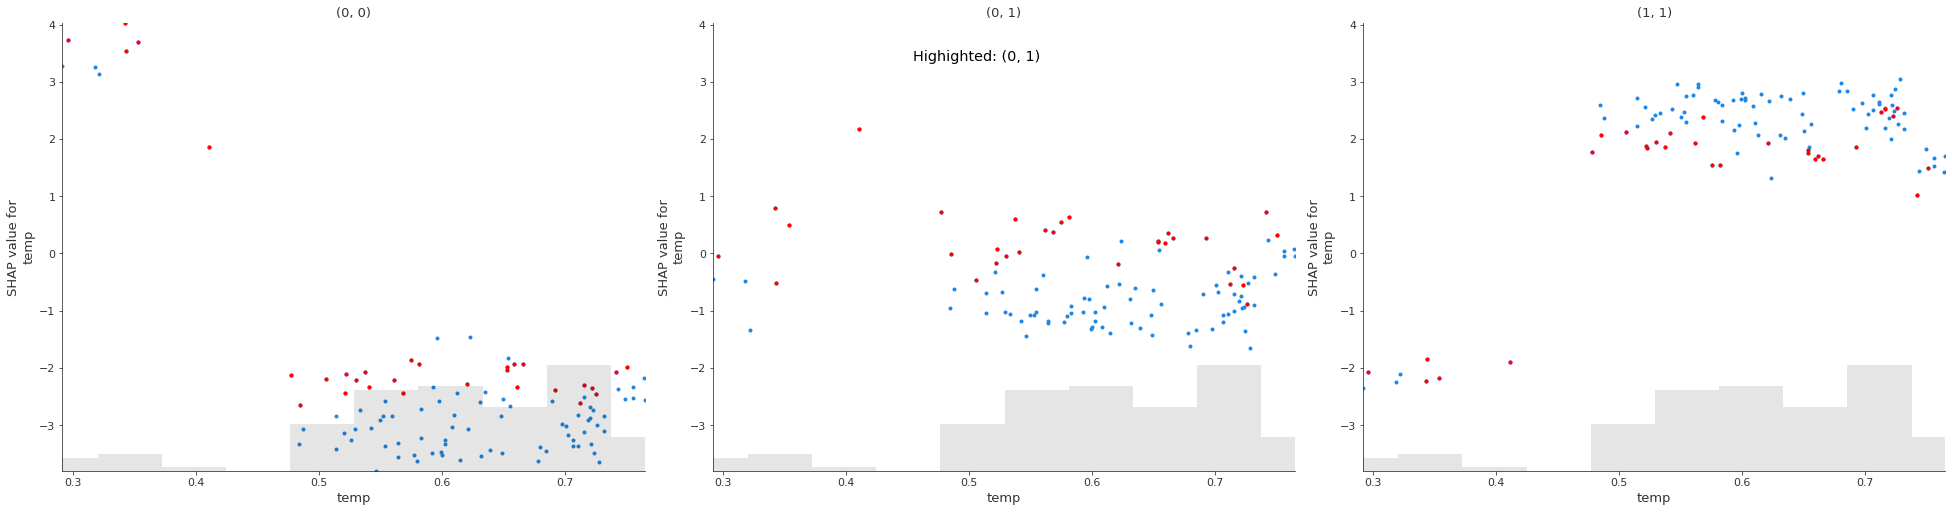

In [93]:
plot_feature('temp')

In [94]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,8
"(0, 1)",30.0,22


In [95]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",30.0,28
"(1, 1)",NaN,2


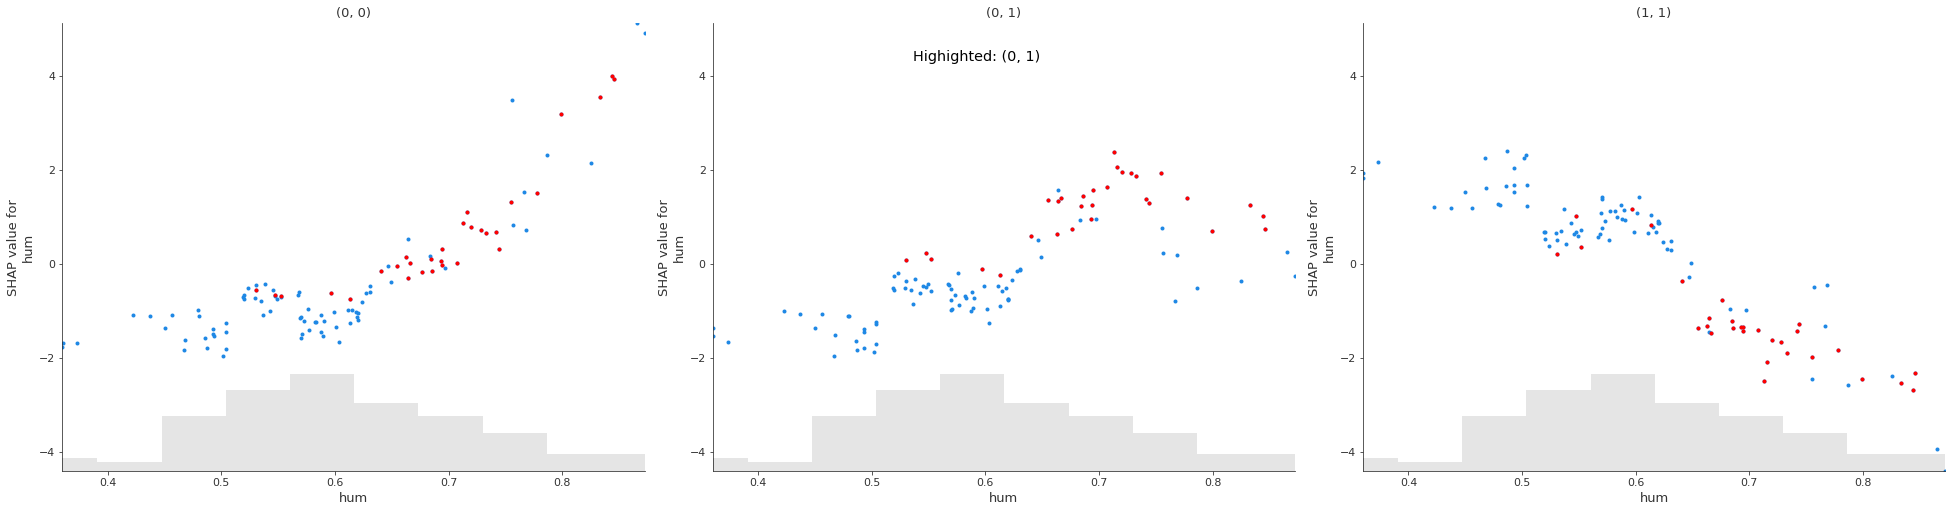

In [96]:
plot_feature('hum')

In [97]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",30.0,9
"(1, 1)",NaN,21


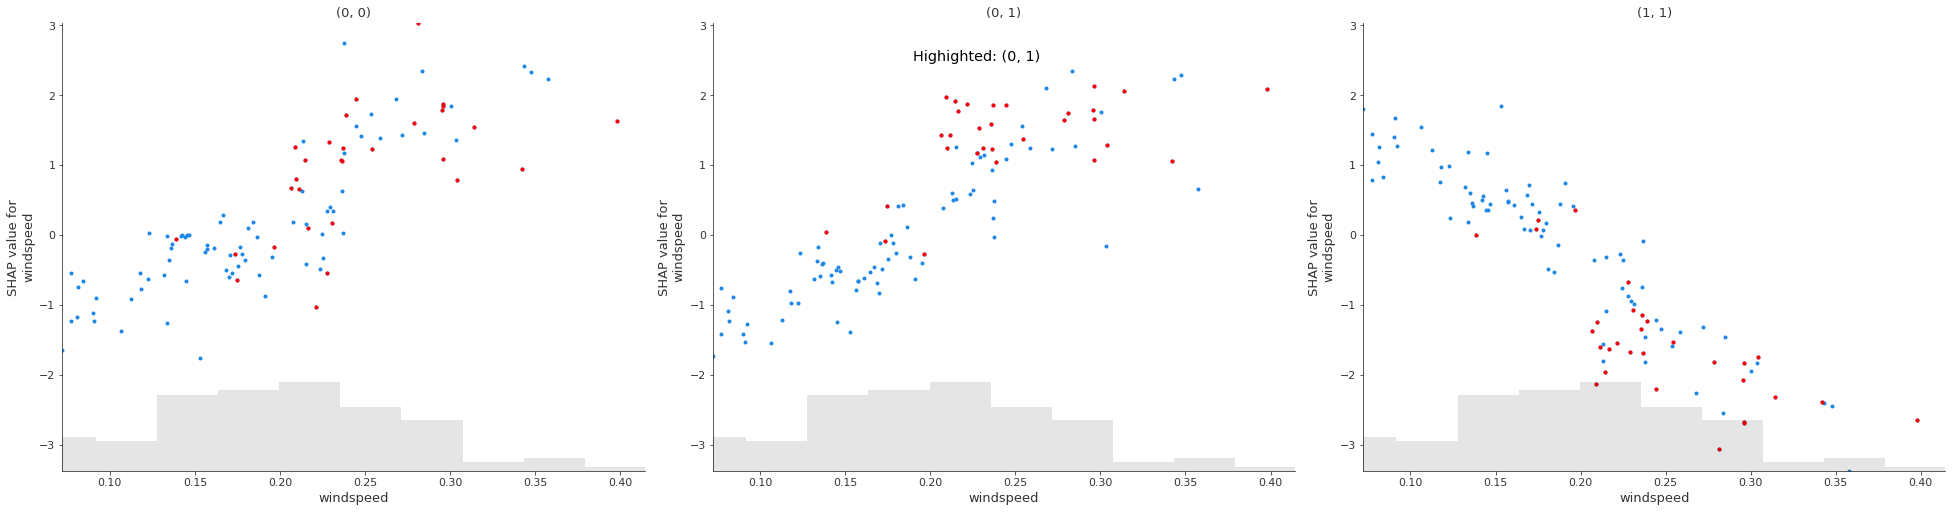

In [98]:
plot_feature('windspeed')

In [99]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['windspeed'] = 0.1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,1
"(0, 1)",30.0,7
"(1, 1)",NaN,22


In [100]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['windspeed'] = 0.1
X_test['hum'] = 0.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,1
"(0, 1)",30.0,5
"(1, 1)",NaN,24


In [101]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['windspeed'] = 0.1
X_test['hum'] = 0.4
X_test['temp'] = 0.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",30.0,1
"(1, 1)",NaN,29


A concludes with B on the positive class for low windspeed values of 0.1, relatively low hum values of 0.4 and relatively high temp values of 0.6 in 1 out of 30 cases.

### Cluster 3

In [232]:
node, shap_values, pred_classes = get_next(node, parent_nodes, traversed_nodes)

Level 1
(0, 1)    113
(0, 0)     22
(1, 1)      6
(1, 0)      2
dtype: int64


In [103]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [104]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.490139,6.972028,2.776224,0.591573,0.188888,1.321678,0.476192,3.097902,0.692308,0.027972
std,0.164536,3.570111,1.103258,0.143092,0.080310,0.497903,0.145184,1.994057,0.463161,0.165472
min,0.245833,1.000000,1.000000,0.254167,0.046650,1.000000,0.248742,0.000000,0.000000,0.000000
25%,0.369167,4.000000,2.000000,0.492083,0.129354,1.000000,0.375621,1.000000,0.000000,0.000000
50%,0.442500,7.000000,3.000000,0.570000,0.173513,1.000000,0.437488,3.000000,1.000000,0.000000
75%,0.562917,11.000000,4.000000,0.674584,0.233838,2.000000,0.540727,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [105]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,0.505501,6.690265,2.707965,0.566239,0.194374,1.185841,0.489573,3.000000,0.743363,0.035398
std,0.168610,3.446219,1.082997,0.131743,0.082180,0.390711,0.149540,1.885092,0.438723,0.185607
min,0.255833,1.000000,1.000000,0.254167,0.046650,1.000000,0.248742,0.000000,0.000000,0.000000
25%,0.383333,4.000000,2.000000,0.485000,0.129354,1.000000,0.381317,1.000000,0.000000,0.000000
50%,0.457500,7.000000,3.000000,0.561667,0.181596,1.000000,0.452637,3.000000,1.000000,0.000000
75%,0.572500,11.000000,4.000000,0.645417,0.236950,1.000000,0.548617,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,2.000000,0.804913,6.000000,1.000000,1.000000


#### Going Down

In [233]:
node, shap_values, pred_classes = go_down(node, parent_nodes, traversed_nodes)

Level 2
(0, 1)    24
(1, 1)     3
dtype: int64


In [234]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [235]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.786296,7.222222,2.962963,0.581697,0.165008,1.148148,0.734879,3.148148,0.703704,0.037037
std,0.031432,0.800641,0.192450,0.080526,0.049820,0.362014,0.028349,1.974914,0.465322,0.192450
min,0.736667,6.000000,2.000000,0.447083,0.110700,1.000000,0.702038,0.000000,0.000000,0.000000
25%,0.764583,7.000000,3.000000,0.512292,0.127796,1.000000,0.709615,1.500000,0.000000,0.000000
50%,0.781667,7.000000,3.000000,0.592083,0.163554,1.000000,0.731079,3.000000,1.000000,0.000000
75%,0.810833,8.000000,3.000000,0.643750,0.185325,1.000000,0.751900,5.000000,1.000000,0.000000
max,0.861667,9.000000,3.000000,0.741250,0.290421,2.000000,0.804913,6.000000,1.000000,1.000000


In [236]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.789306,7.125000,2.958333,0.579826,0.170269,1.125000,0.738722,3.041667,0.708333,0.041667
std,0.031767,0.740887,0.204124,0.081081,0.050393,0.337832,0.027735,1.988645,0.464306,0.204124
min,0.736667,6.000000,2.000000,0.447083,0.110700,1.000000,0.702038,0.000000,0.000000,0.000000
25%,0.768334,7.000000,3.000000,0.515521,0.133551,1.000000,0.719392,1.000000,0.000000,0.000000
50%,0.782083,7.000000,3.000000,0.584583,0.164802,1.000000,0.733277,3.000000,1.000000,0.000000
75%,0.816458,7.250000,3.000000,0.643125,0.189363,1.000000,0.752535,5.000000,1.000000,0.000000
max,0.861667,9.000000,3.000000,0.741250,0.290421,2.000000,0.804913,6.000000,1.000000,1.000000


- $0.73 < temp$
- $6 ≤ mnth ≤ 9$
- $2 ≤ season ≤ 3$
- $0.44 < hum < 0.75$
- $windspeed < 0.30$
- $0.70 < atemp$

A concludes with B on the positive class for lower hum values of 0.44, lower temp values of 0.6 and lower atemp values of 0.65 in 20 out of 24 cases.

In [110]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,12
"(1, 1)",NaN,12


In [111]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.44
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,19
"(1, 1)",NaN,5


In [112]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.44
X_test['temp'] = 0.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,11
"(1, 1)",NaN,13


In [113]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.65
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,4
"(1, 1)",NaN,20


In [114]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.44
X_test['temp'] = 0.6
X_test['atemp'] = 0.65
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,NaN
"(1, 1)",NaN,24.0


In [238]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24,24


In [243]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.3
X_test['atemp'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,3
"(0, 1)",24.0,19
"(1, 0)",NaN,1
"(1, 1)",NaN,1


In [246]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 2
X_test['season'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24,24


In [247]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 2
X_test['season'] = 1
X_test['temp'] = 0.3
X_test['atemp'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,24.0
"(0, 1)",24.0,NaN


if mnth was February, season was winter, temp was lower (≤0.3) and atemp was lower (≤0.3), both would predict the negative class

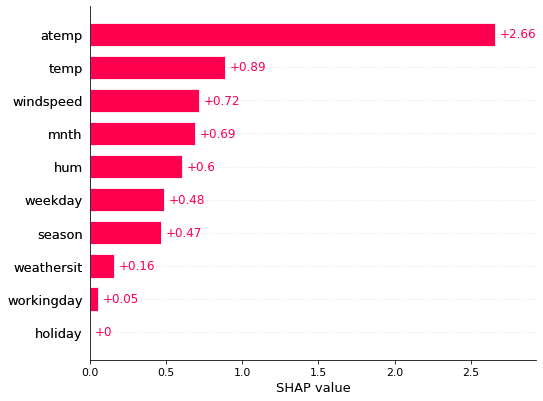

In [115]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, np.unique(pred_classes)])
plot_feature_importance_bar(feature_importances)

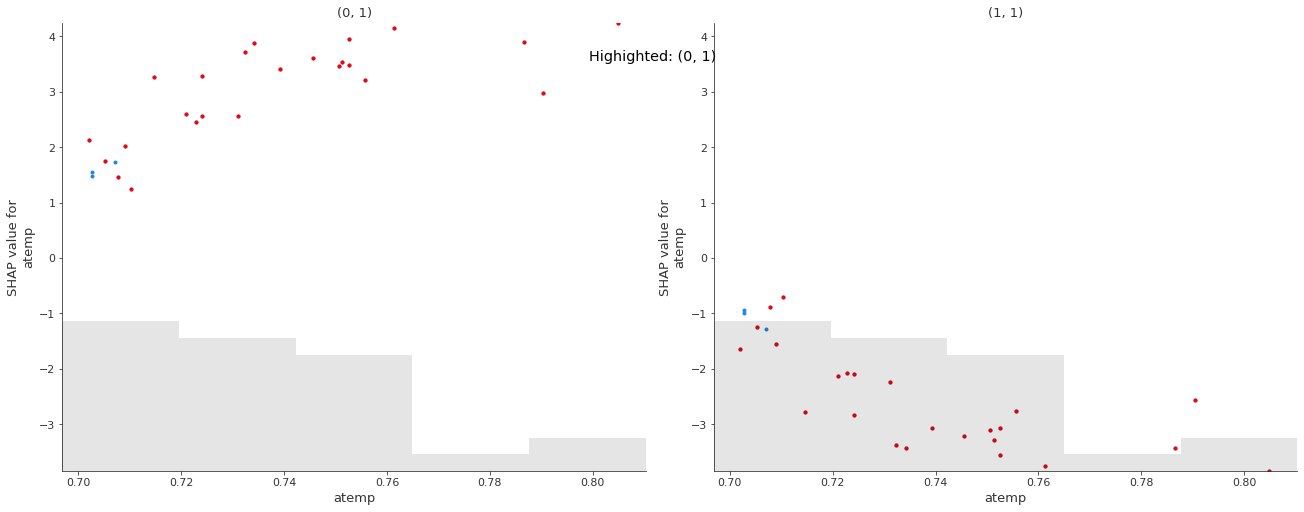

In [116]:
plot_feature('atemp')

In [117]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.7
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,4
"(1, 1)",NaN,20


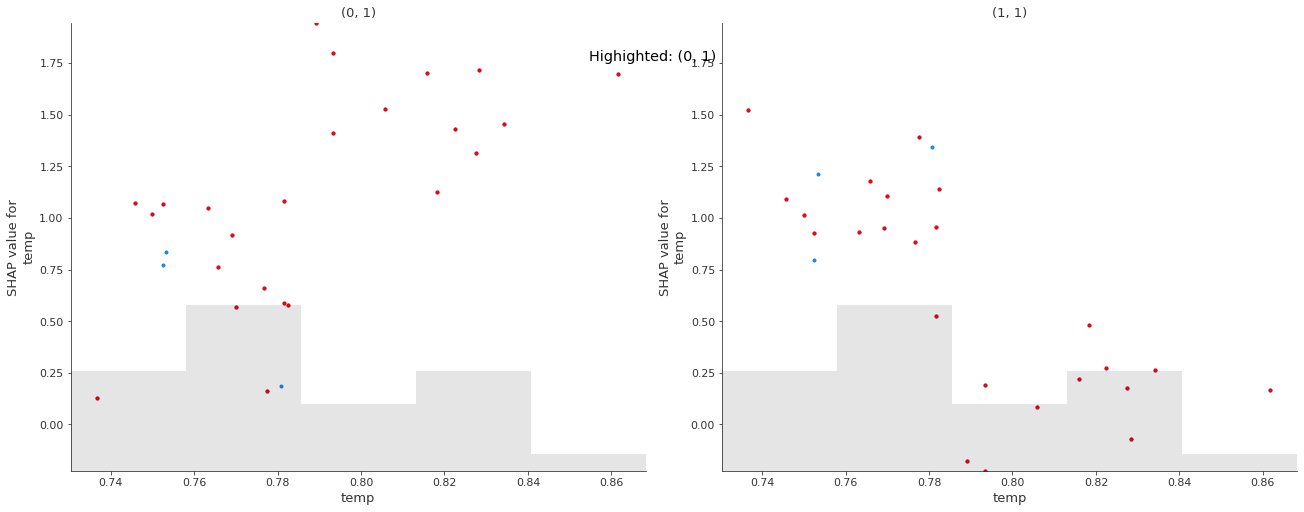

In [118]:
plot_feature('temp')

In [119]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.74
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,22
"(1, 1)",NaN,2


In [120]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.74
X_test['atemp'] = 0.7
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,3
"(1, 1)",NaN,21


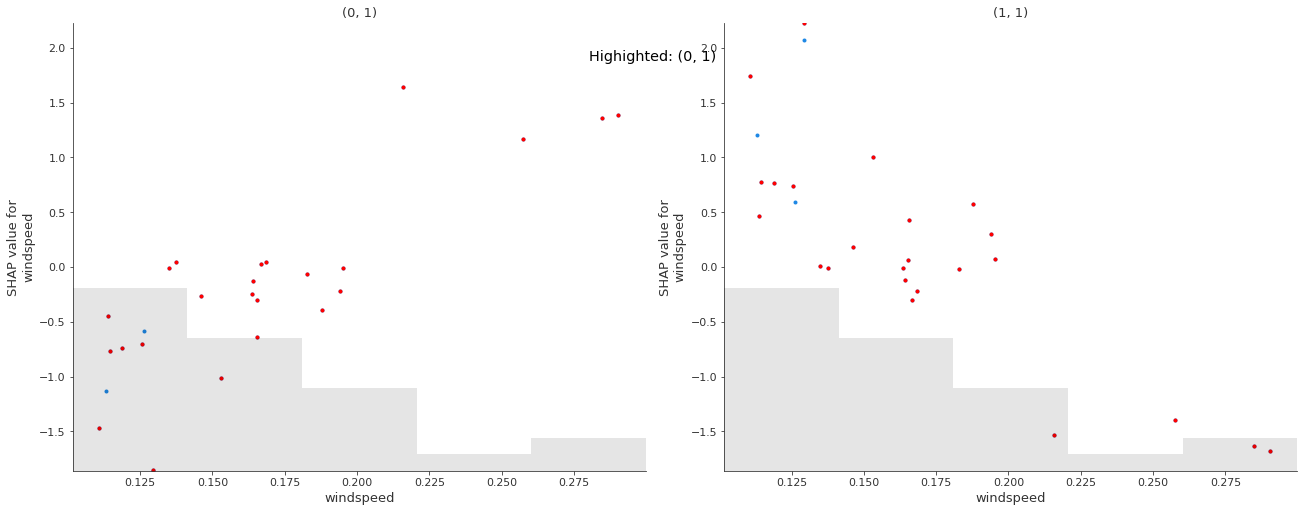

In [121]:
plot_feature('windspeed')

In [122]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['windspeed'] = 0.12
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,23
"(1, 1)",NaN,1


In [123]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.74
X_test['atemp'] = 0.7
X_test['windspeed'] = 0.12
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",24.0,1
"(1, 1)",NaN,23


A concludes with B on the positive class for relatively low temp values of 0.74, relatively low atemp values of 0.7 and relatively low windspeed values of 0.12 in 23 out of 24 cases.

### Cluster 4

In [248]:
node, shap_values, pred_classes = get_next(node, parent_nodes, traversed_nodes)

Level 2
(0, 1)    89
(0, 0)    22
(1, 1)     3
(1, 0)     2
dtype: int64


In [125]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [126]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,0.421206,6.913793,2.732759,0.593872,0.194446,1.362069,0.415981,3.086207,0.689655,0.025862
std,0.088427,3.946532,1.218394,0.154234,0.085076,0.517461,0.080482,2.006810,0.464642,0.159412
min,0.245833,1.000000,1.000000,0.254167,0.046650,1.000000,0.248742,0.000000,0.000000,0.000000
25%,0.354583,3.000000,2.000000,0.489479,0.130444,1.000000,0.358417,1.000000,0.000000,0.000000
50%,0.422500,4.000000,2.000000,0.567708,0.179418,1.000000,0.418550,3.000000,1.000000,0.000000
75%,0.470000,11.000000,4.000000,0.694271,0.236481,2.000000,0.464635,5.000000,1.000000,0.000000
max,0.664167,12.000000,4.000000,0.925000,0.441563,3.000000,0.614925,6.000000,1.000000,1.000000


In [127]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.428969,6.573034,2.640449,0.562575,0.200874,1.202247,0.422387,2.988764,0.752809,0.033708
std,0.089601,3.860899,1.208372,0.142505,0.087923,0.403951,0.082251,1.867755,0.433823,0.181499
min,0.255833,1.000000,1.000000,0.254167,0.046650,1.000000,0.248742,0.000000,0.000000,0.000000
25%,0.361667,3.000000,2.000000,0.476957,0.127500,1.000000,0.359670,1.000000,1.000000,0.000000
50%,0.435833,4.000000,2.000000,0.552083,0.189067,1.000000,0.431163,3.000000,1.000000,0.000000
75%,0.484167,11.000000,4.000000,0.649583,0.250617,1.000000,0.470950,4.000000,1.000000,0.000000
max,0.664167,12.000000,4.000000,0.925000,0.441563,2.000000,0.614925,6.000000,1.000000,1.000000


- $0.24 < temp < 0.67$
- $0.24 < atemp < 0.62$

In [128]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.24
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,28
"(0, 1)",89.0,61


In [129]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.24
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,2
"(0, 1)",89.0,87


In [130]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.24
X_test['temp'] = 0.24
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,31
"(0, 1)",89.0,58


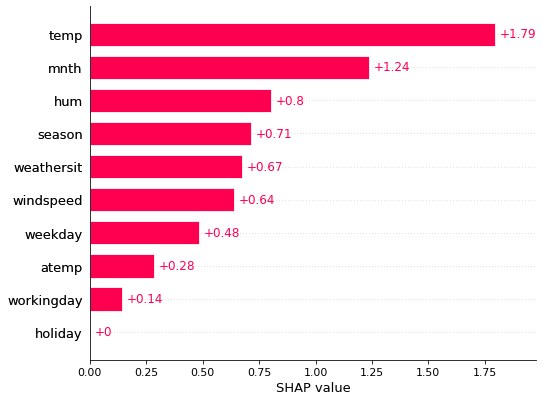

In [131]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, np.unique(pred_classes)])
plot_feature_importance_bar(feature_importances)

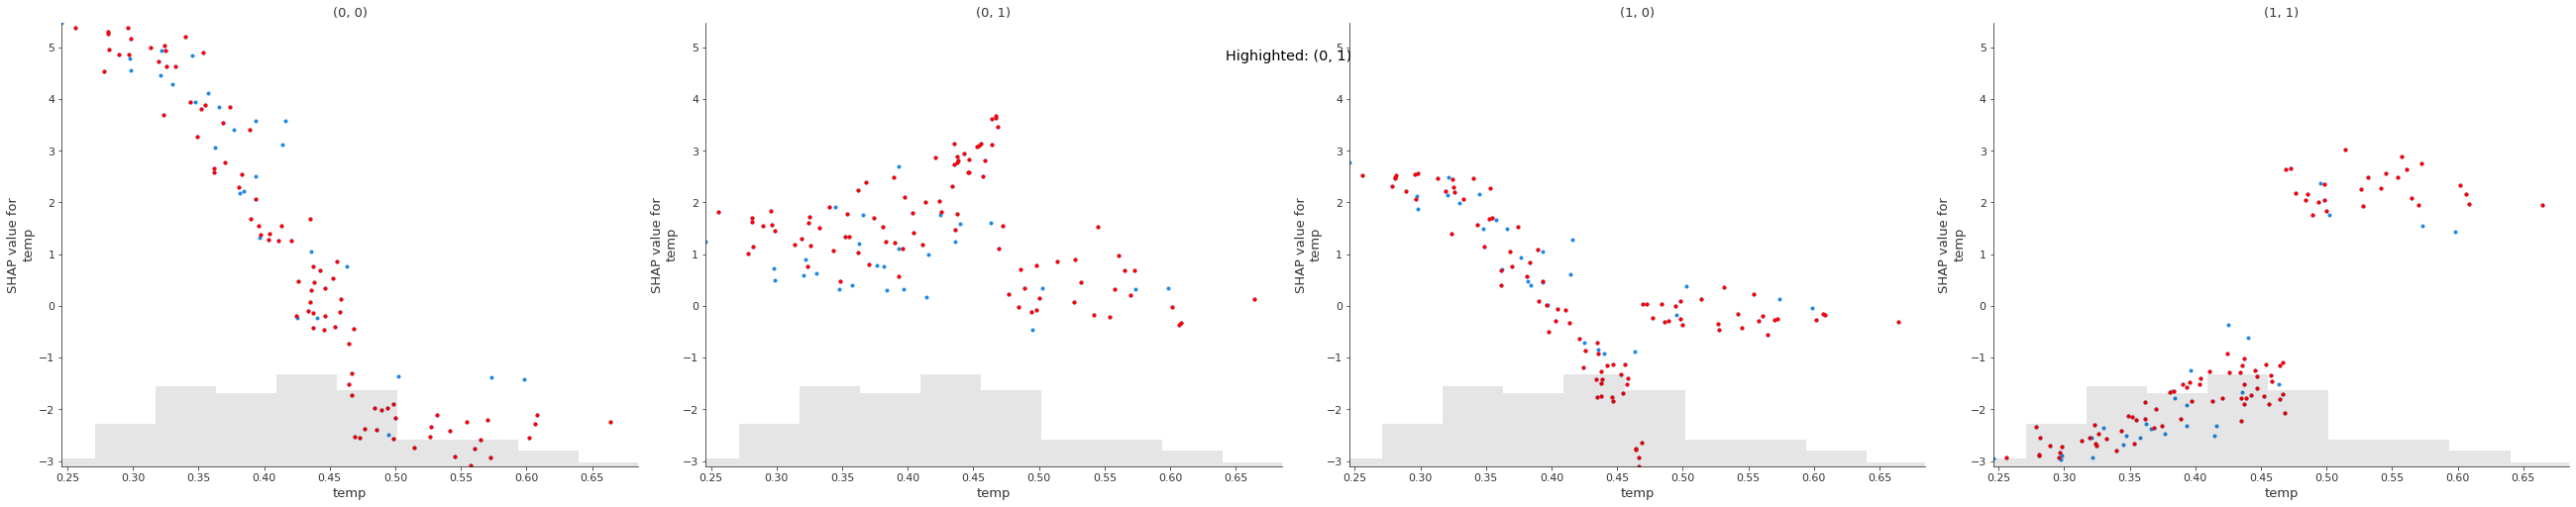

In [132]:
plot_feature('temp')

In [133]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,28
"(0, 1)",89.0,61


In [134]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",89.0,54
"(1, 1)",NaN,35


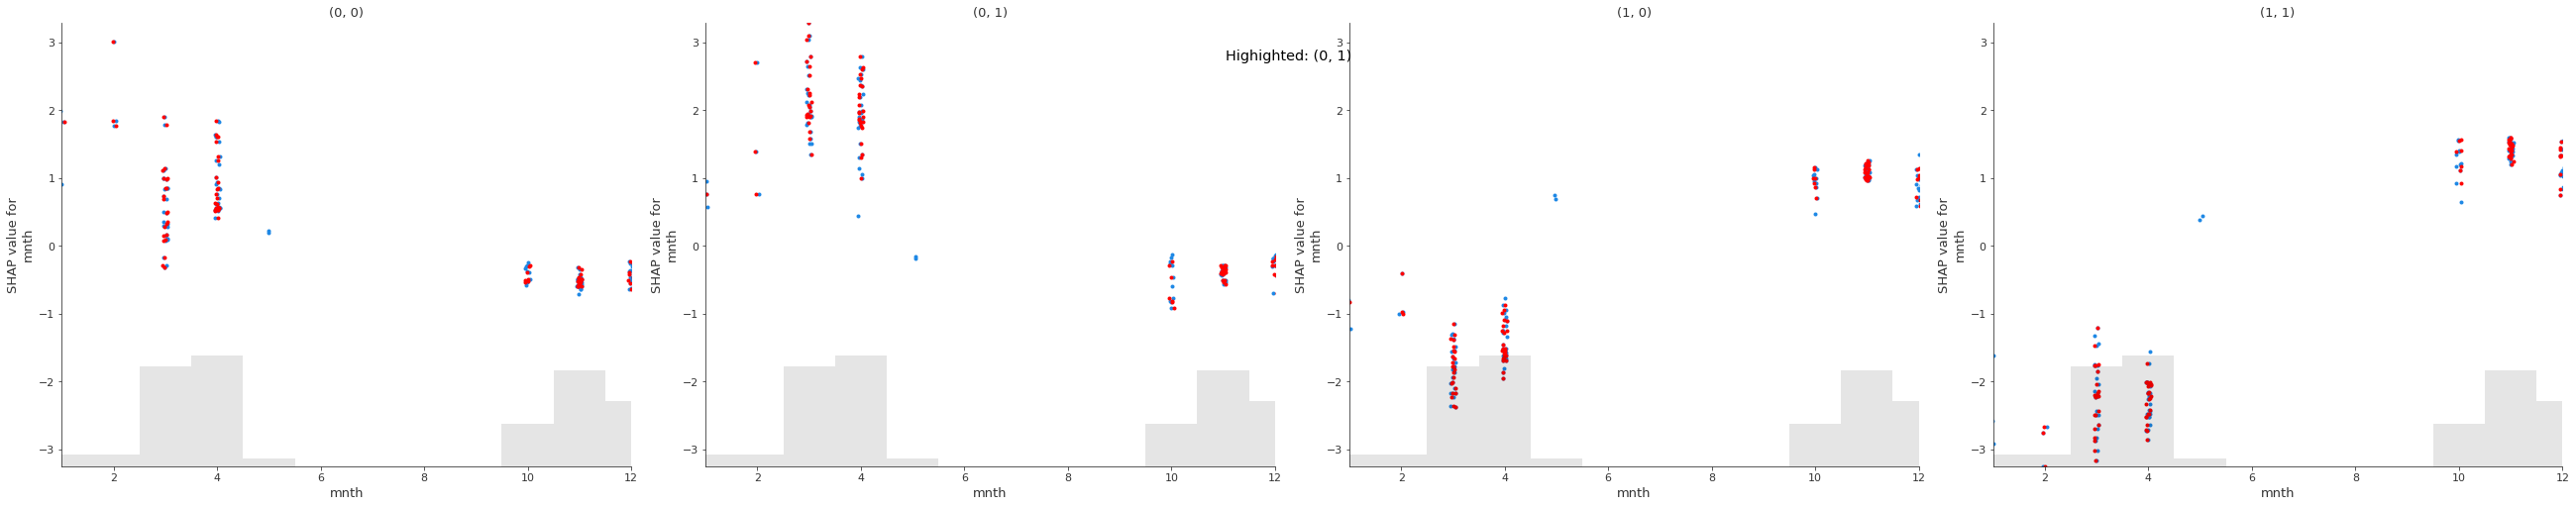

In [135]:
plot_feature('mnth')

In [136]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 12
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,1
"(0, 1)",89.0,67
"(1, 1)",NaN,21


In [137]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 12
X_test['temp'] = 0.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",89.0,14
"(1, 1)",NaN,75


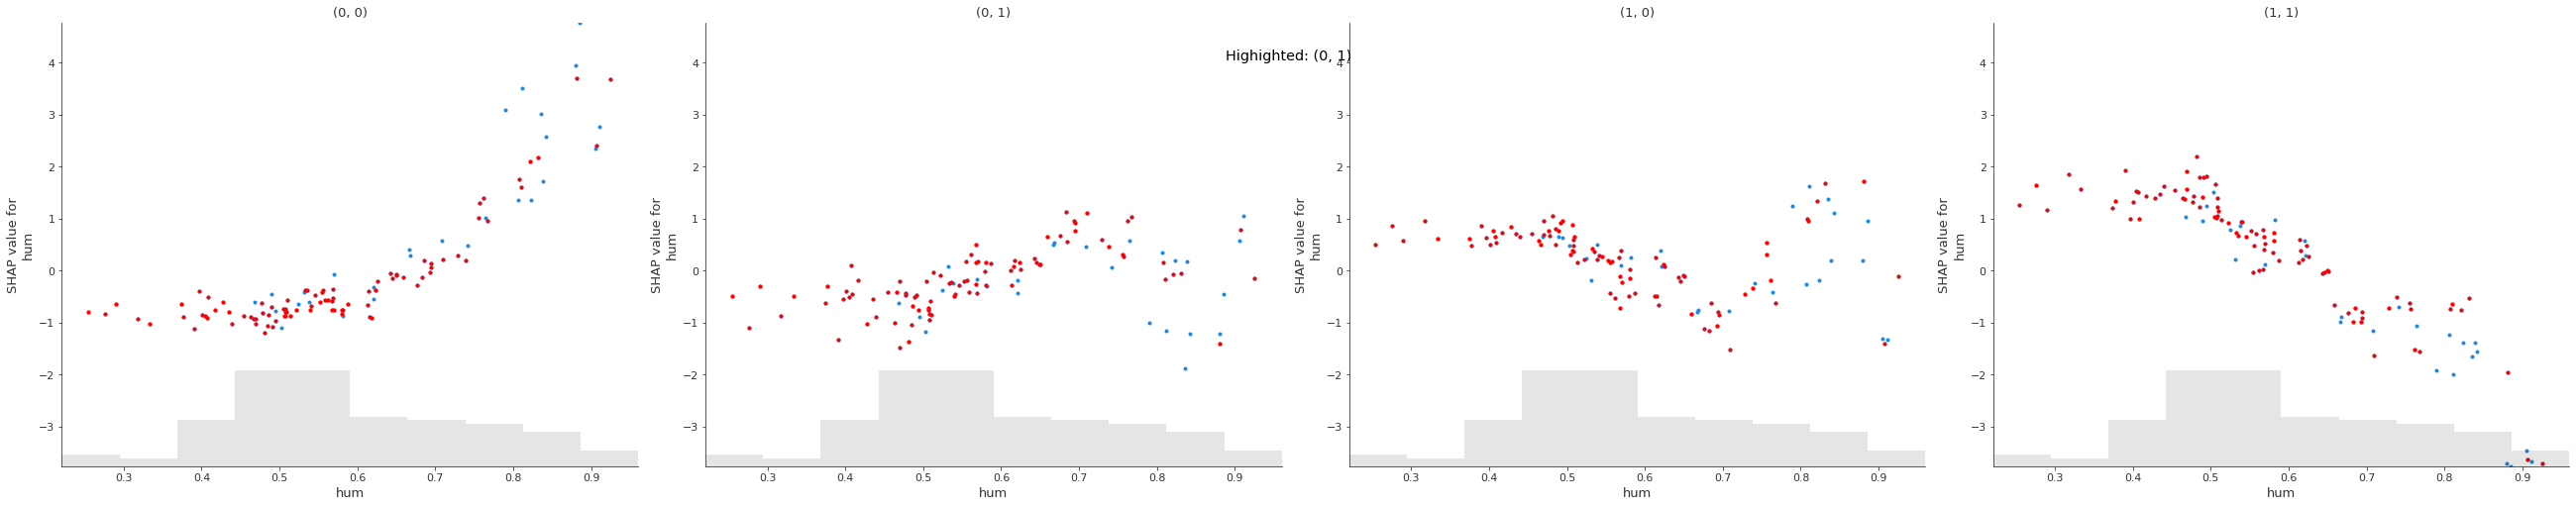

In [138]:
plot_feature('hum')

In [139]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",89.0,81
"(1, 1)",NaN,8


In [140]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 12
X_test['temp'] = 0.5
X_test['hum'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",89.0,NaN
"(1, 1)",NaN,89.0


In [141]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.9
X_test['temp'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,44
"(0, 1)",89.0,45


#### Going Down

In [249]:
node, shap_values, pred_classes = go_down(node, parent_nodes, traversed_nodes)

Level 3
(0, 1)    33
(0, 0)     6
(1, 1)     1
dtype: int64


In [143]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [144]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,40.000000,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.484240,3.15000,1.575000,0.574955,0.213309,1.300000,0.471807,3.625000,0.700000,0.025000
std,0.081804,0.83359,0.500641,0.156288,0.091152,0.464095,0.074260,1.807215,0.464095,0.158114
min,0.323333,1.00000,1.000000,0.275833,0.065929,1.000000,0.315654,0.000000,0.000000,0.000000
25%,0.413334,3.00000,1.000000,0.475114,0.136044,1.000000,0.409390,2.750000,0.000000,0.000000
50%,0.494584,3.00000,2.000000,0.564584,0.191850,1.000000,0.482943,4.000000,1.000000,0.000000
75%,0.544792,4.00000,2.000000,0.694271,0.276118,2.000000,0.531882,5.000000,1.000000,0.000000
max,0.664167,4.00000,2.000000,0.885417,0.441563,2.000000,0.614925,6.000000,1.000000,1.000000


In [145]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.494761,3.242424,1.606061,0.557092,0.219000,1.212121,0.480732,3.181818,0.787879,0.030303
std,0.084091,0.708445,0.496198,0.151057,0.094229,0.415149,0.076780,1.666856,0.415149,0.174078
min,0.323333,1.000000,1.000000,0.275833,0.065929,1.000000,0.315654,0.000000,0.000000,0.000000
25%,0.424167,3.000000,1.000000,0.469565,0.138067,1.000000,0.421708,2.000000,1.000000,0.000000
50%,0.498333,3.000000,2.000000,0.561667,0.225129,1.000000,0.492425,3.000000,1.000000,0.000000
75%,0.557500,4.000000,2.000000,0.682917,0.283587,1.000000,0.533450,4.000000,1.000000,0.000000
max,0.664167,4.000000,2.000000,0.831250,0.441563,2.000000,0.614925,6.000000,1.000000,1.000000


- $0.32 < temp < 0.67$
- $1 ≤ mnth ≤ 4$
- $1 ≤ season ≤ 2$
- $0.31 < atemp < 0.62$

A concludes with B on the positive class for a higher season of 3, higher mnth of 6 and higher atemp of 0.62 in 28 out of 33 cases.

In [146]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.32
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,16
"(0, 1)",33.0,17


In [147]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,1
"(0, 1)",33.0,10
"(1, 1)",NaN,22


In [148]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['season'] = 3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33.0,27
"(1, 1)",NaN,6


In [149]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['season'] = 3
X_test['mnth'] = 6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33.0,9
"(1, 1)",NaN,24


In [150]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.31
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,2
"(0, 1)",33.0,31


In [151]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.62
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33.0,23
"(1, 1)",NaN,10


In [152]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['season'] = 3
X_test['mnth'] = 6
X_test['atemp'] = 0.62
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33.0,5
"(1, 1)",NaN,28


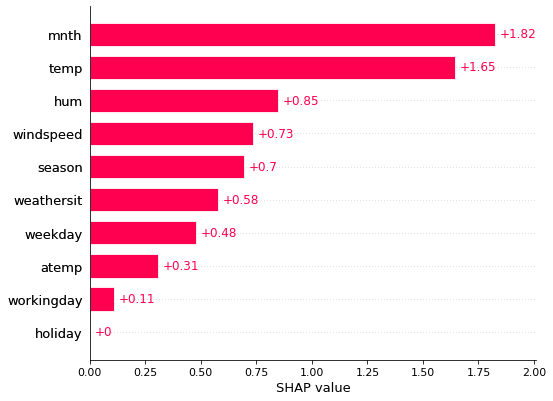

In [153]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, np.unique(pred_classes)])
plot_feature_importance_bar(feature_importances)

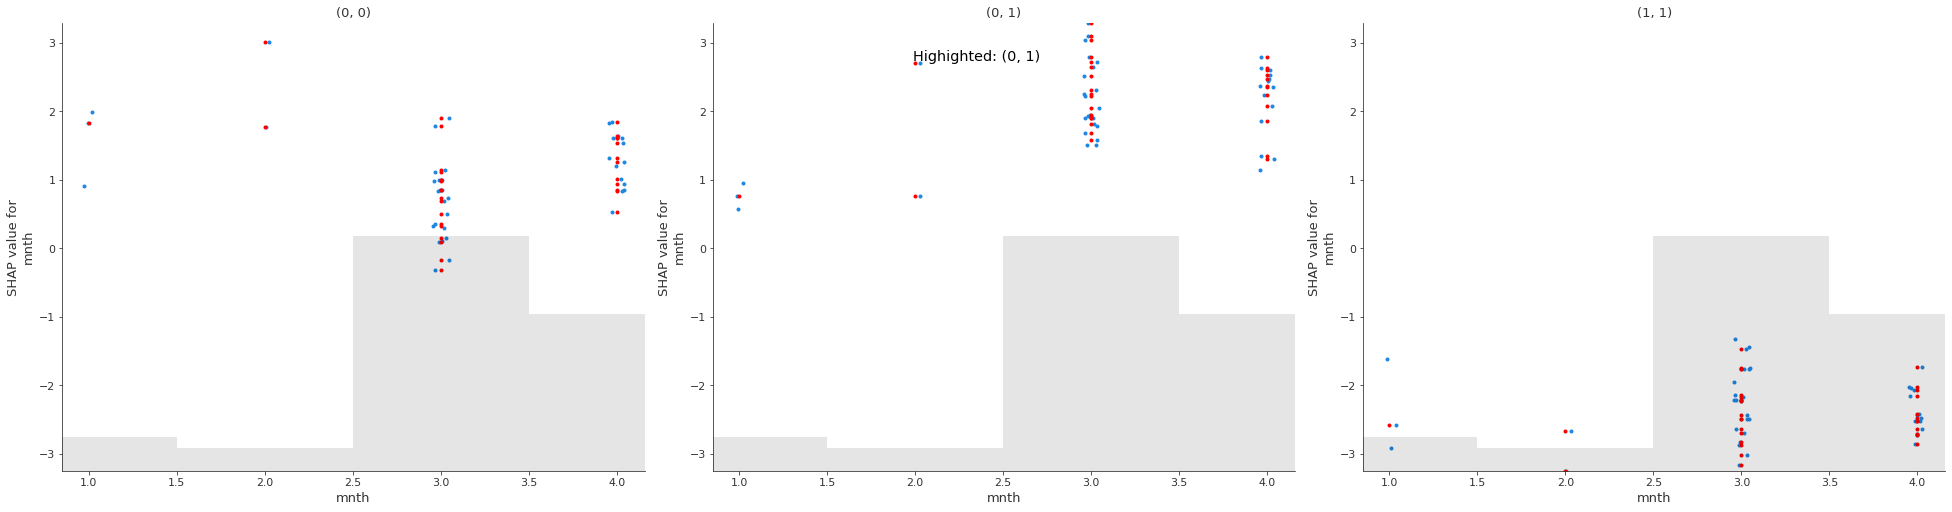

In [154]:
plot_feature('mnth')

In [155]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33,33


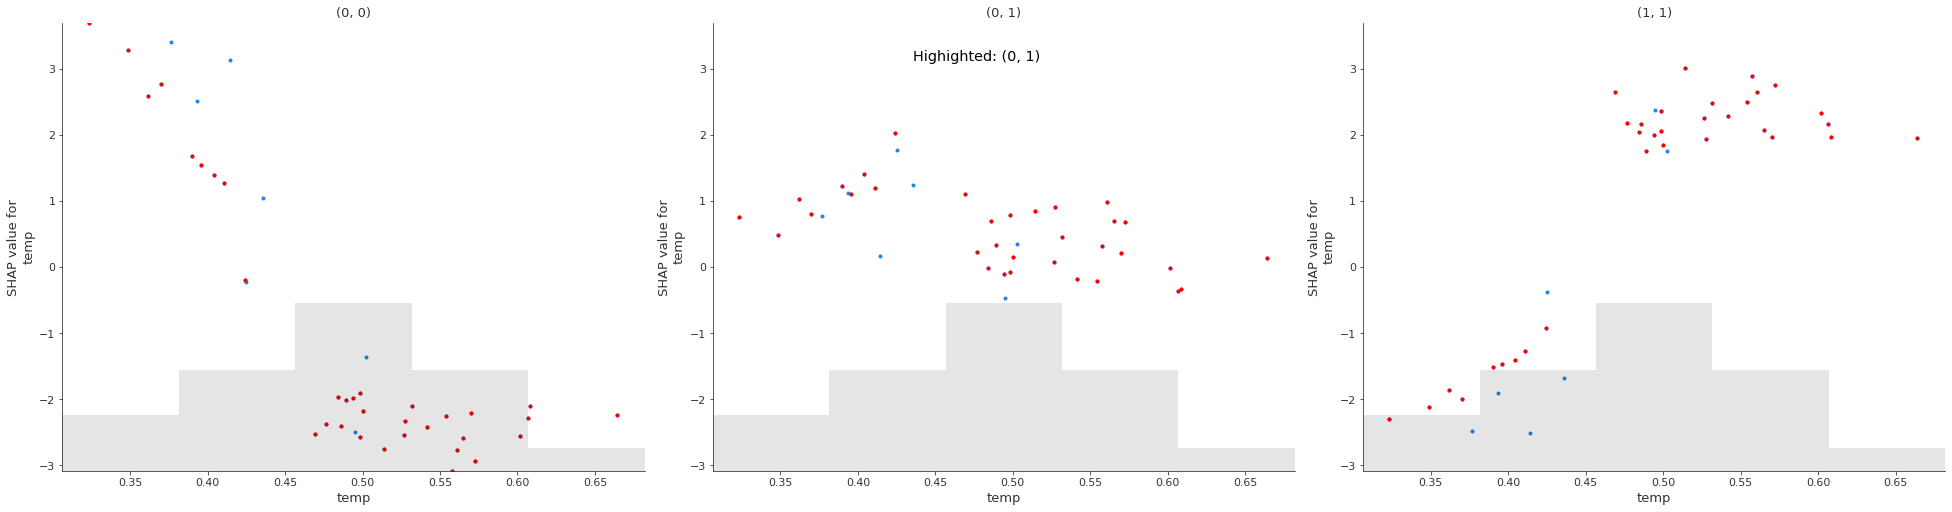

In [156]:
plot_feature('temp')

In [157]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33.0,31
"(1, 1)",NaN,2


In [158]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,5
"(0, 1)",33.0,28


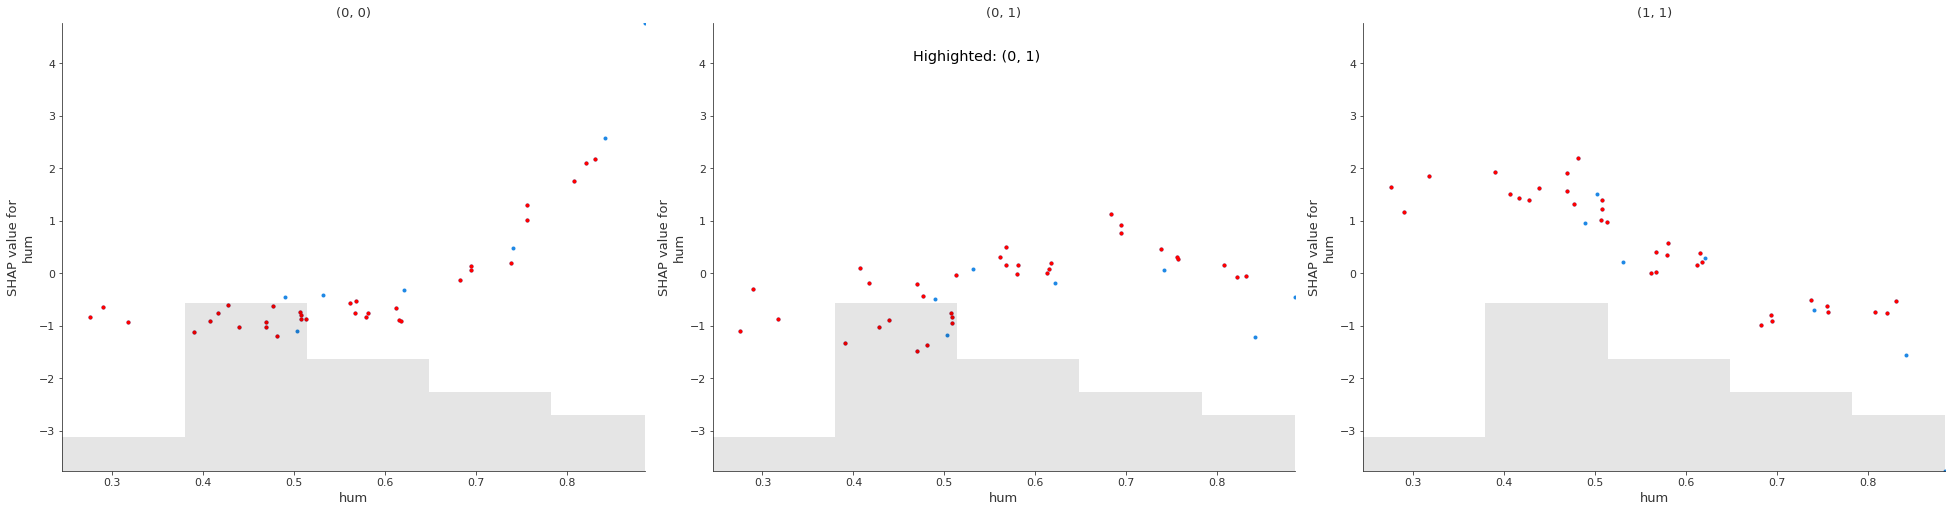

In [159]:
plot_feature('hum')

In [160]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33.0,30
"(1, 1)",NaN,3


In [161]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.8
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,4
"(0, 1)",33.0,26
"(1, 1)",NaN,3


In [162]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.3
X_test['temp'] = 0.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33.0,29
"(1, 1)",NaN,4


In [163]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.8
X_test['temp'] = 0.4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,10
"(0, 1)",33.0,23


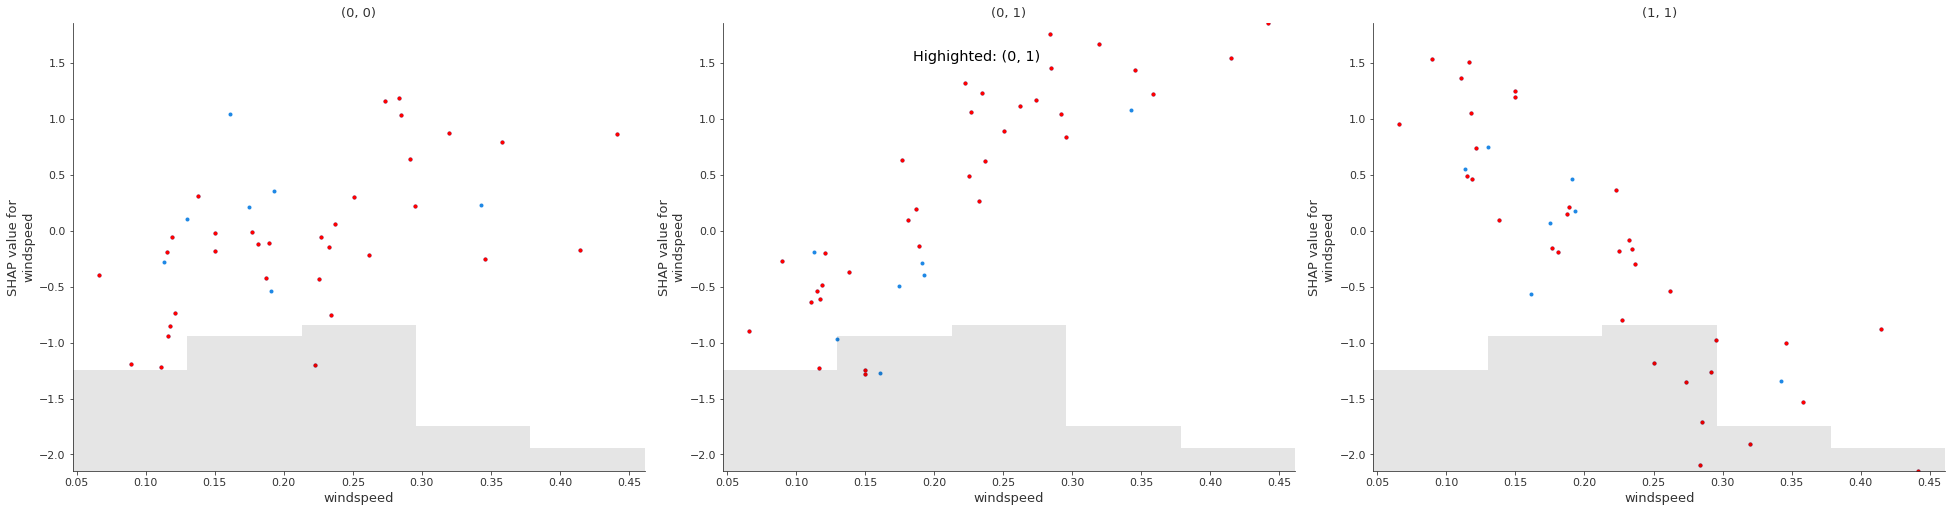

In [164]:
plot_feature('windspeed')

In [165]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['windspeed'] = 0.05
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,4
"(0, 1)",33.0,26
"(1, 1)",NaN,3


In [166]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['windspeed'] = 0.45
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,3
"(0, 1)",33.0,30


In [167]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.3
X_test['temp'] = 0.5
X_test['windspeed'] = 0.05
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33.0,24
"(1, 1)",NaN,9


In [168]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.8
X_test['temp'] = 0.4
X_test['windspeed'] = 0.45
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,9
"(0, 1)",33.0,24


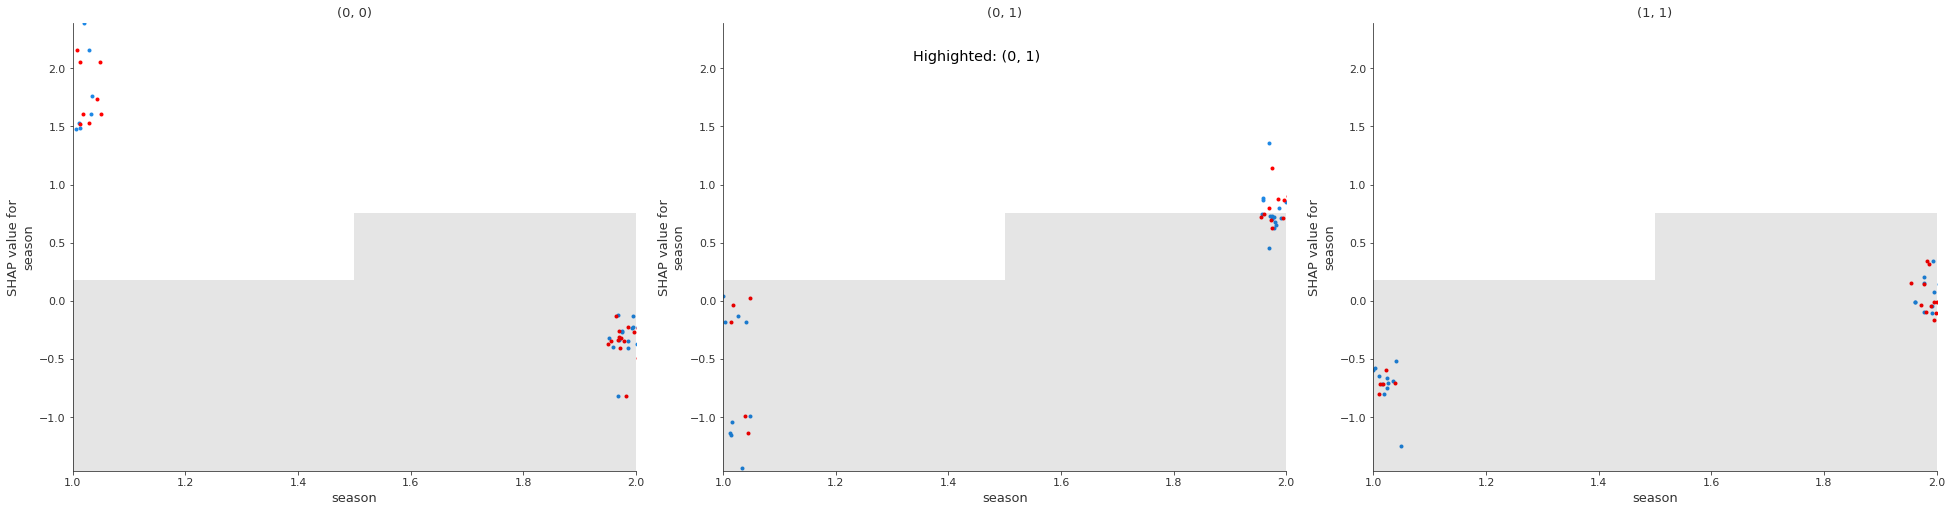

In [169]:
plot_feature('season')

In [170]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['season'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,3
"(0, 1)",33.0,30


In [171]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['season'] = 1
X_test['hum'] = 0.8
X_test['temp'] = 0.4
X_test['windspeed'] = 0.45
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,13
"(0, 1)",33.0,20


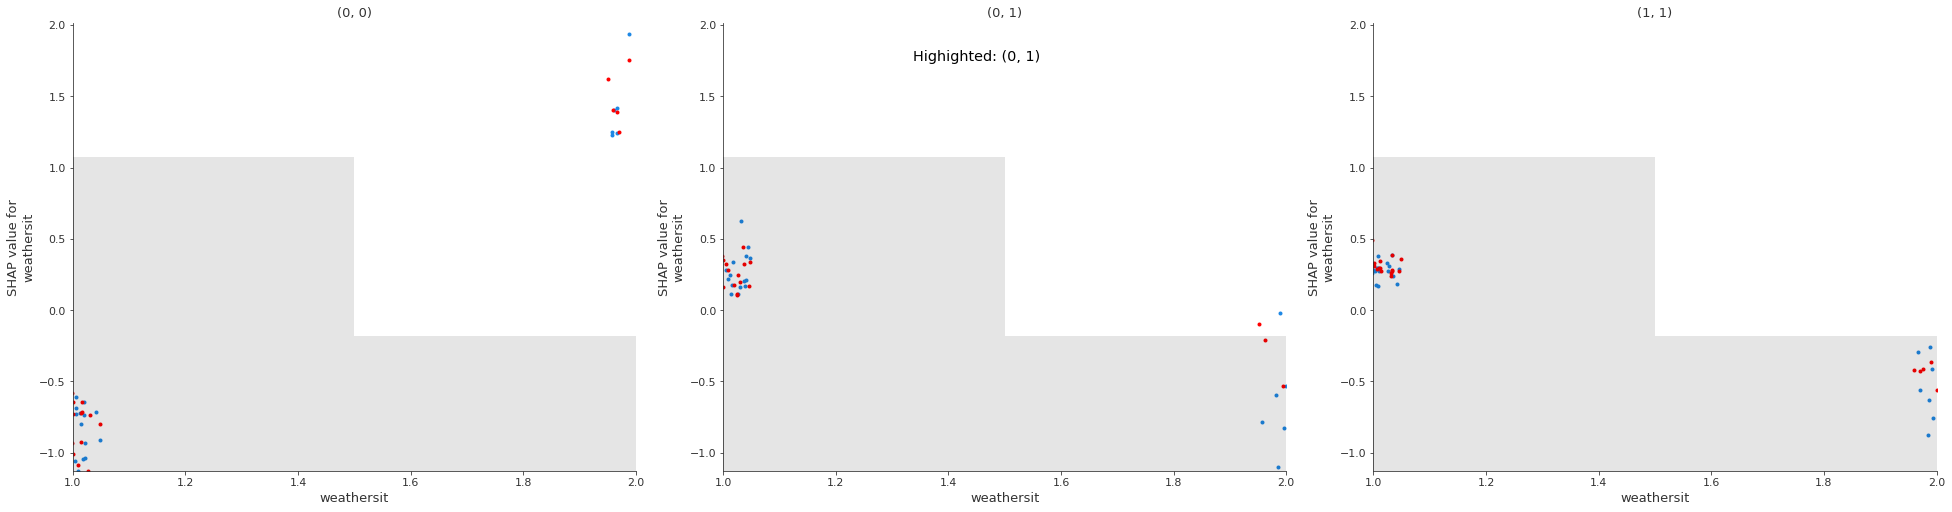

In [172]:
plot_feature('weathersit')

In [173]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['weathersit'] = 2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",33,33


In [174]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['season'] = 1
X_test['hum'] = 0.8
X_test['temp'] = 0.4
X_test['windspeed'] = 0.45
X_test['weathersit'] = 2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,33.0
"(0, 1)",33.0,NaN


B starts to predict the positive class earlier than A above a relatively low season of 1, below a relatively high hum of 0.8, above a relatively low temp of 0.4, below a relatively high windspeed of 0.45 and below a high weathersit of 2 in all 33 cases.

### Cluster 5

In [250]:
node, shap_values, pred_classes = get_next(node, parent_nodes, traversed_nodes)

Level 3
(0, 1)    56
(0, 0)    16
(1, 1)     2
(1, 0)     2
dtype: int64


In [251]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [252]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.388030,8.894737,3.342105,0.603829,0.184518,1.394737,0.386599,2.802632,0.684211,0.026316
std,0.072631,3.462481,1.027004,0.153240,0.080547,0.543543,0.067286,2.059254,0.467918,0.161136
min,0.245833,2.000000,1.000000,0.254167,0.046650,1.000000,0.248742,0.000000,0.000000,0.000000
25%,0.328958,4.000000,2.000000,0.494479,0.129825,1.000000,0.337591,1.000000,0.000000,0.000000
50%,0.386667,11.000000,4.000000,0.568958,0.172890,1.000000,0.389506,3.000000,1.000000,0.000000
75%,0.440625,11.000000,4.000000,0.696771,0.223882,2.000000,0.436547,5.000000,1.000000,0.000000
max,0.598333,12.000000,4.000000,0.925000,0.386821,3.000000,0.565667,6.000000,1.000000,1.000000


In [253]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,0.390199,8.535714,3.250000,0.565806,0.190192,1.196429,0.388005,2.875000,0.732143,0.035714
std,0.067850,3.602849,1.082925,0.138519,0.083002,0.400892,0.064407,1.982308,0.446850,0.187256
min,0.255833,2.000000,1.000000,0.254167,0.046650,1.000000,0.248742,0.000000,0.000000,0.000000
25%,0.330833,4.000000,2.000000,0.485625,0.127346,1.000000,0.338849,1.000000,0.000000,0.000000
50%,0.400417,11.000000,4.000000,0.548750,0.181909,1.000000,0.397718,3.000000,1.000000,0.000000
75%,0.446041,11.000000,4.000000,0.646459,0.235400,1.000000,0.437644,5.000000,1.000000,0.000000
max,0.545000,12.000000,4.000000,0.925000,0.386821,2.000000,0.532821,6.000000,1.000000,1.000000


- $0.24 < temp < 0.59$
- $0.24 < atemp < 0.57$

A concludes with B on the positive class for a higher atemp value of 0.6 and a higher temp value of 0.59 in 39 out of 56 cases.

In [179]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.24
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,12
"(0, 1)",56.0,44


In [254]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56,56


In [255]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.24
X_test['atemp'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,14
"(0, 1)",56.0,42


In [180]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.59
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56.0,24
"(1, 1)",NaN,32


In [181]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56.0,42
"(1, 1)",NaN,14


In [182]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.6
X_test['temp'] = 0.59
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56.0,17
"(1, 1)",NaN,39


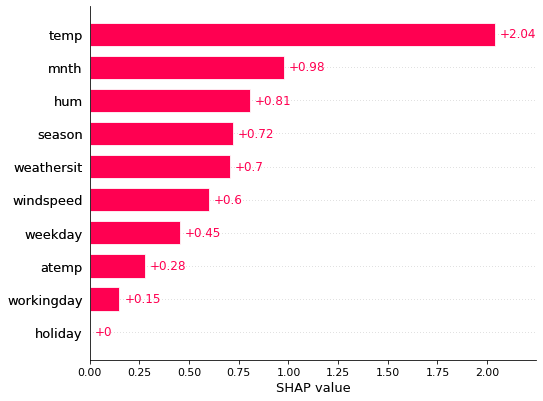

In [256]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, np.unique(pred_classes)])
plot_feature_importance_bar(feature_importances)

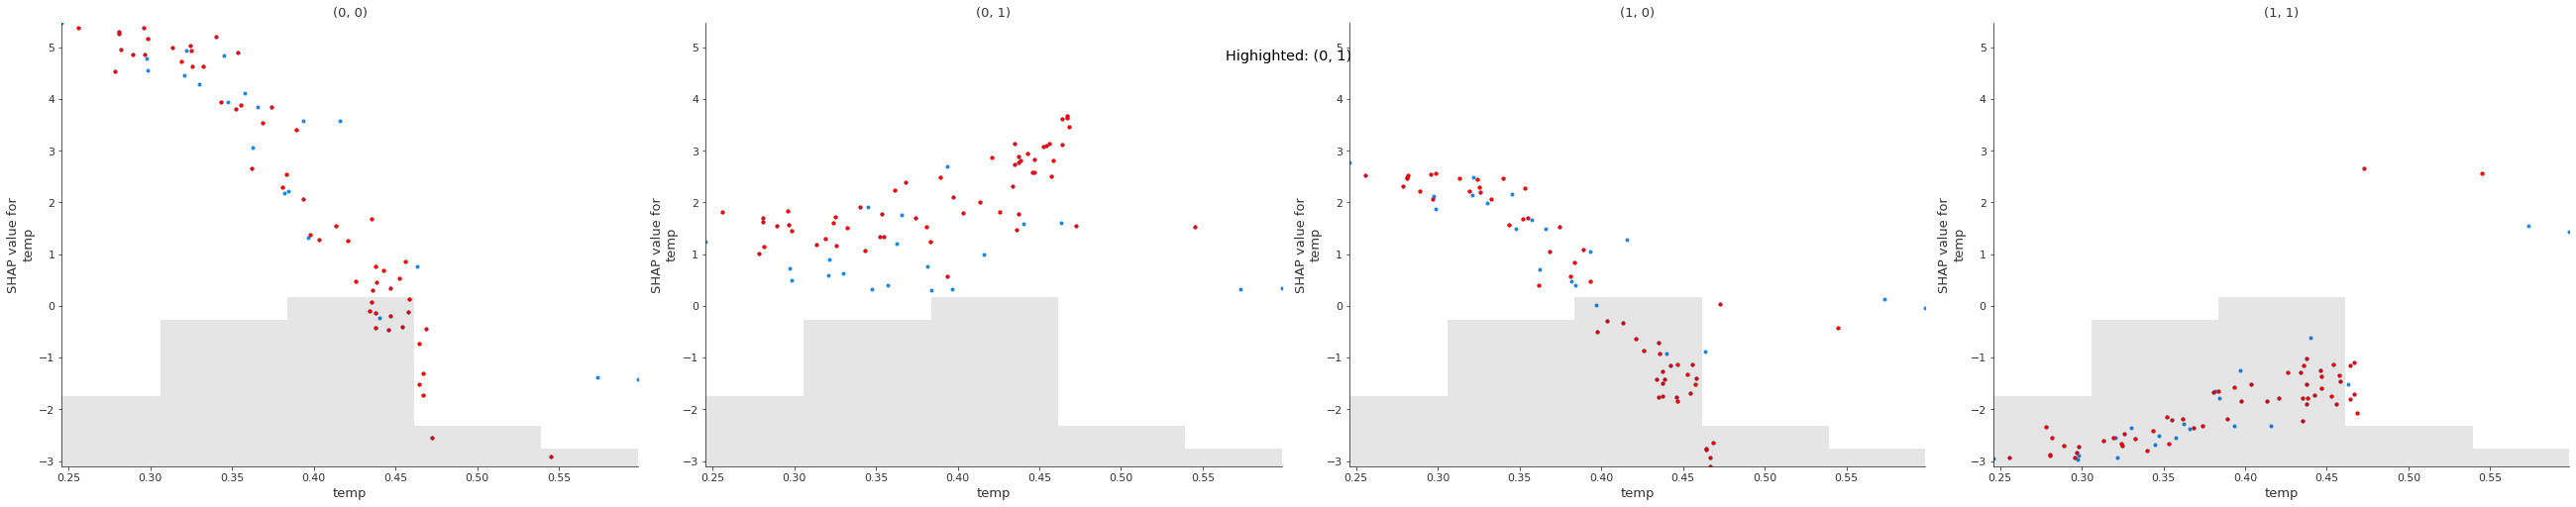

In [184]:
plot_feature('temp')

In [185]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,12
"(0, 1)",56.0,44


In [186]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.55
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56.0,24
"(1, 1)",NaN,32


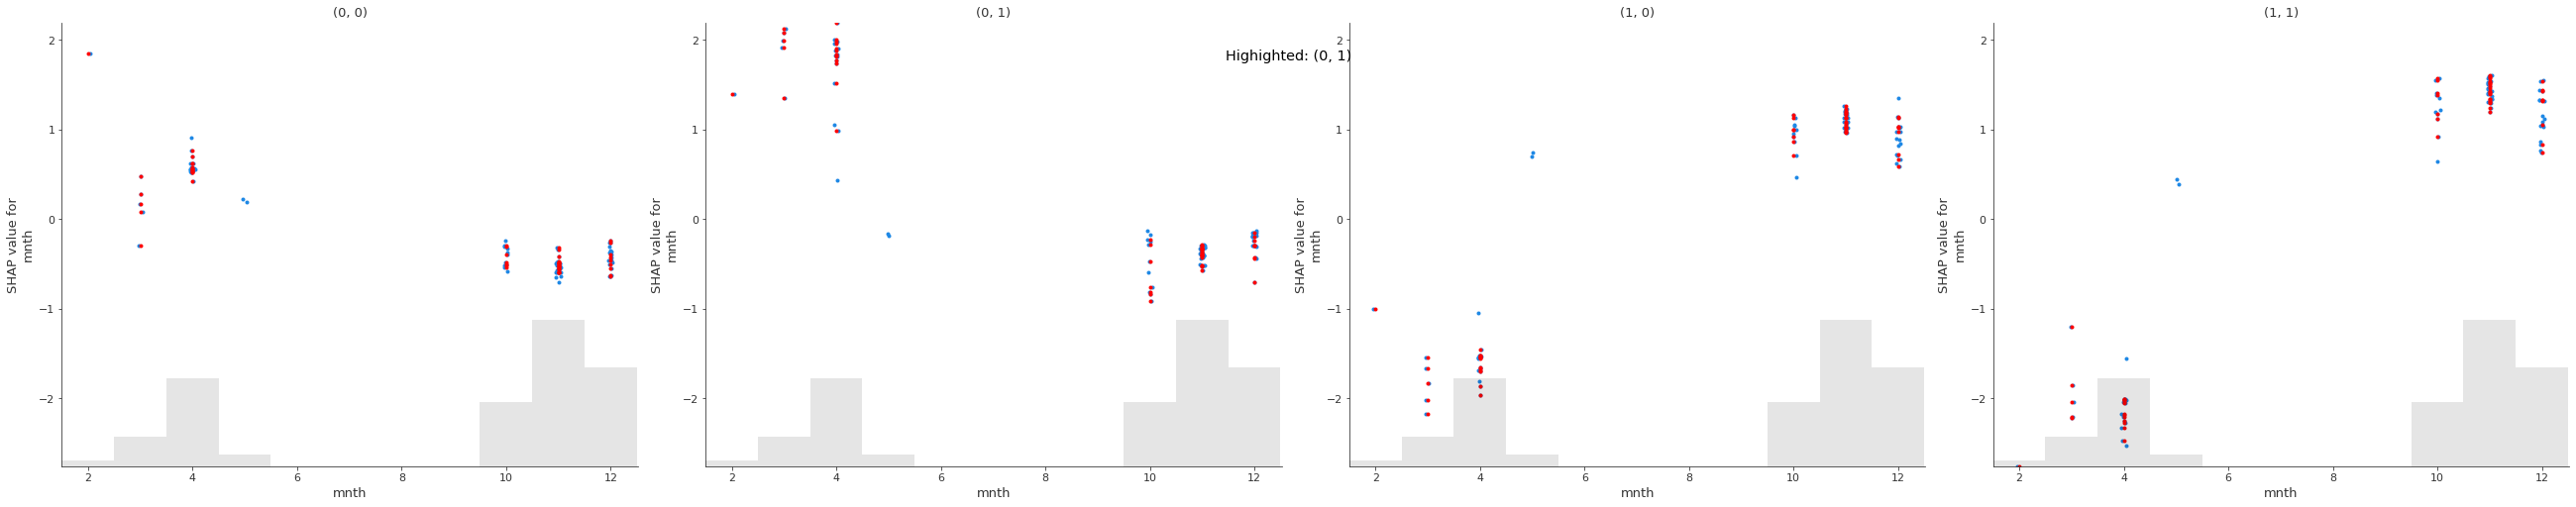

In [187]:
plot_feature('mnth')

In [188]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56,56


In [189]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 5
X_test['temp'] = 0.55
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56.0,17
"(1, 1)",NaN,39


In [257]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56,56


In [258]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 2
X_test['temp'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,13
"(0, 1)",56.0,43


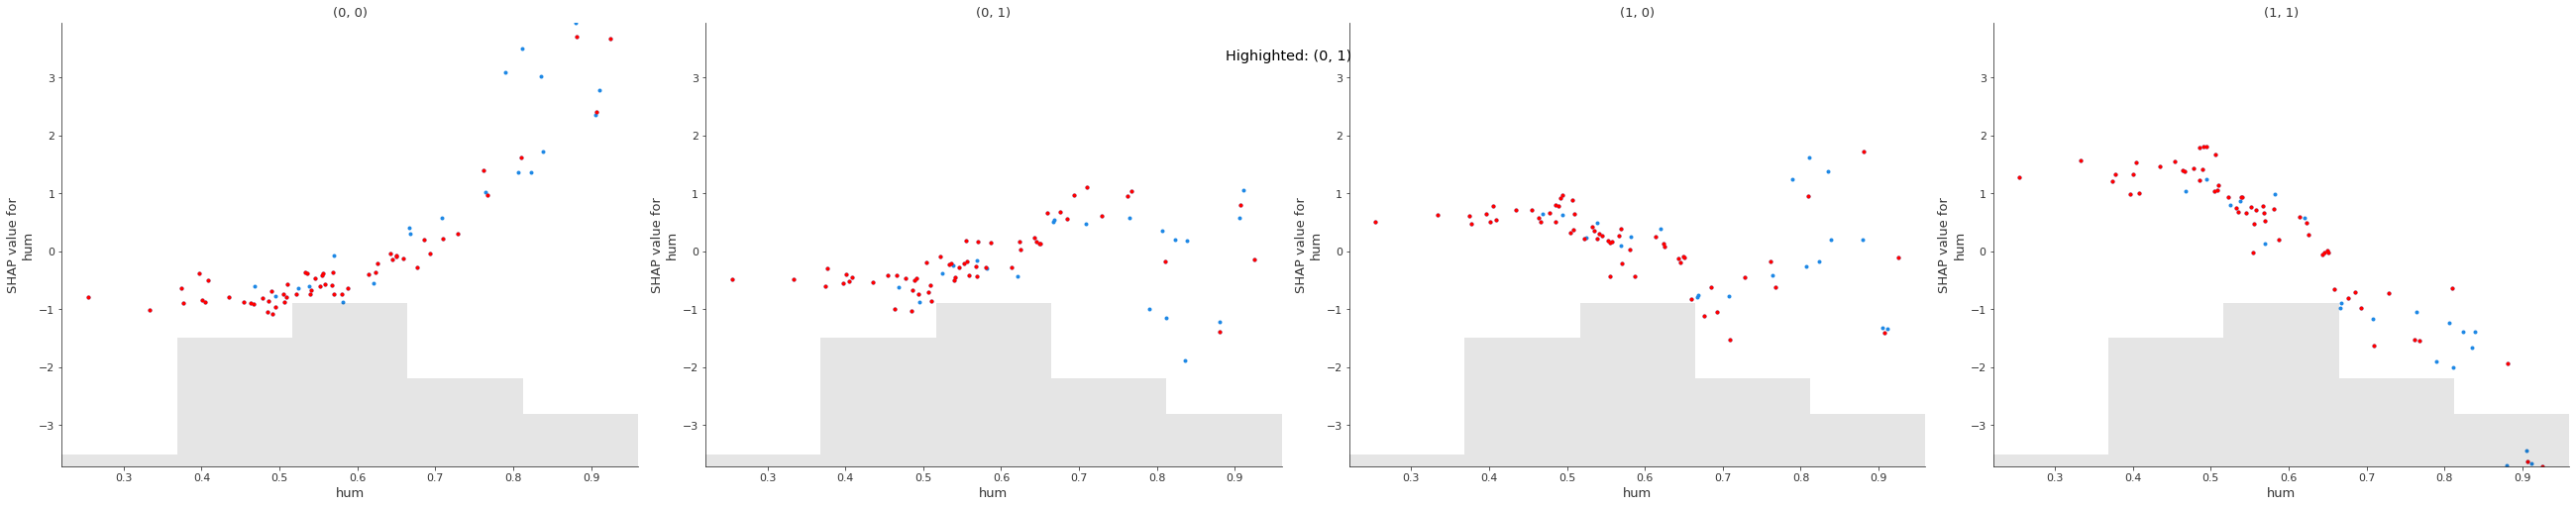

In [190]:
plot_feature('hum')

In [191]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56.0,51
"(1, 1)",NaN,5


In [192]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 5
X_test['temp'] = 0.55
X_test['hum'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56.0,11
"(1, 1)",NaN,45


In [259]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.9
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,7
"(0, 1)",56.0,49


In [260]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.9
X_test['mnth'] = 2
X_test['temp'] = 0.25
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,46
"(0, 1)",56.0,10


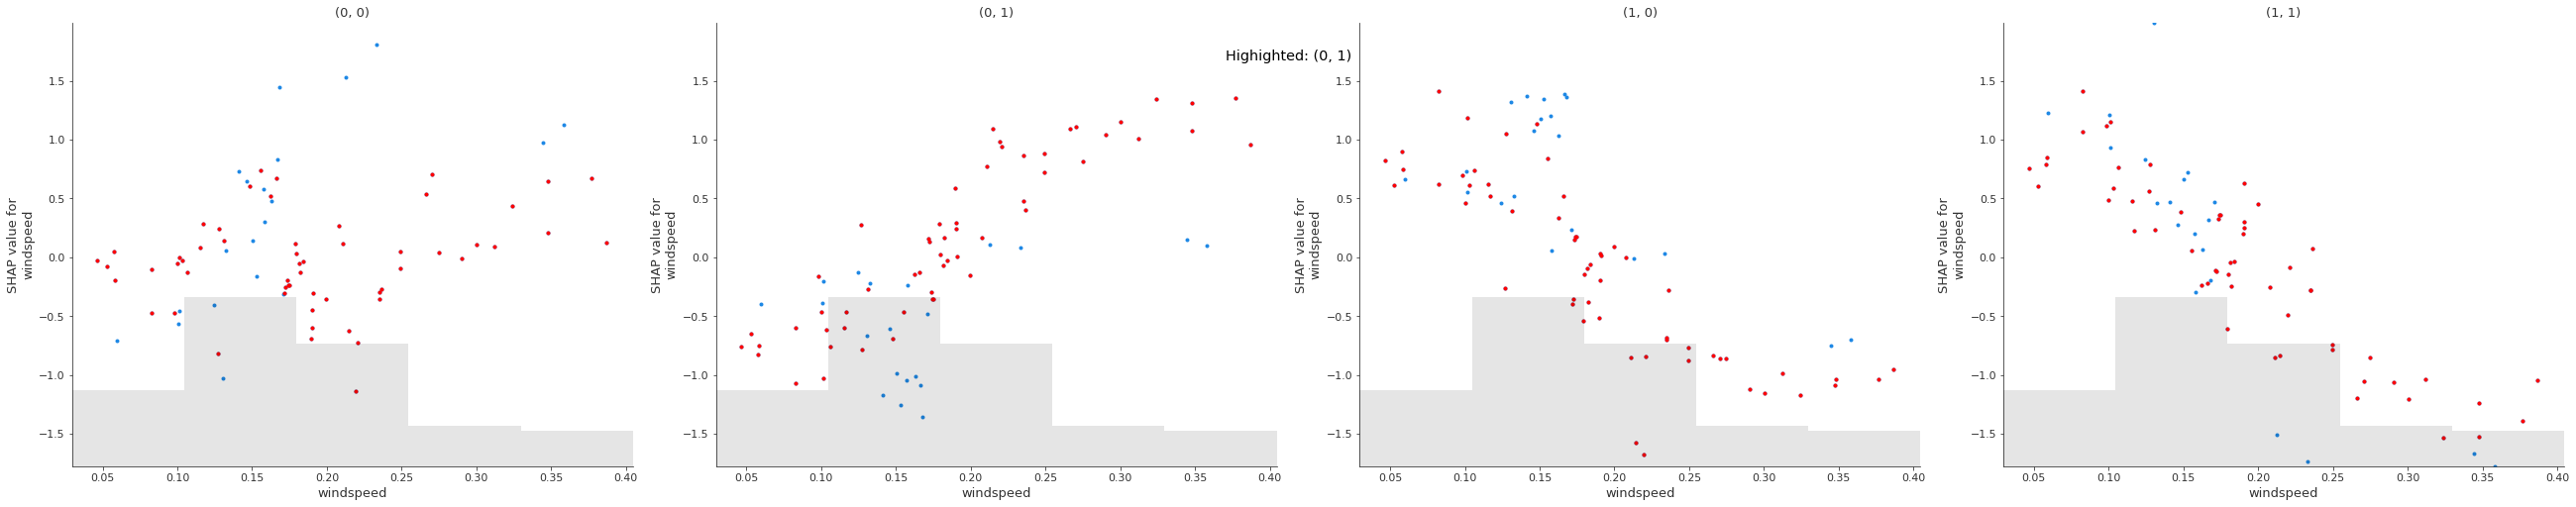

In [193]:
plot_feature('windspeed')

In [194]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['windspeed'] = 0.05
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56.0,54
"(1, 0)",NaN,1
"(1, 1)",NaN,1


In [195]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['mnth'] = 5
X_test['temp'] = 0.55
X_test['hum'] = 0.3
X_test['windspeed'] = 0.05
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56.0,5
"(1, 1)",NaN,51


A concldues with B on the positive class for a mnth value of 5, a relatively high temp value of 0.55, a relatively low hum value of 0.3 and a relatively low windspeed value of 0.05 in 51 out of 56 cases.

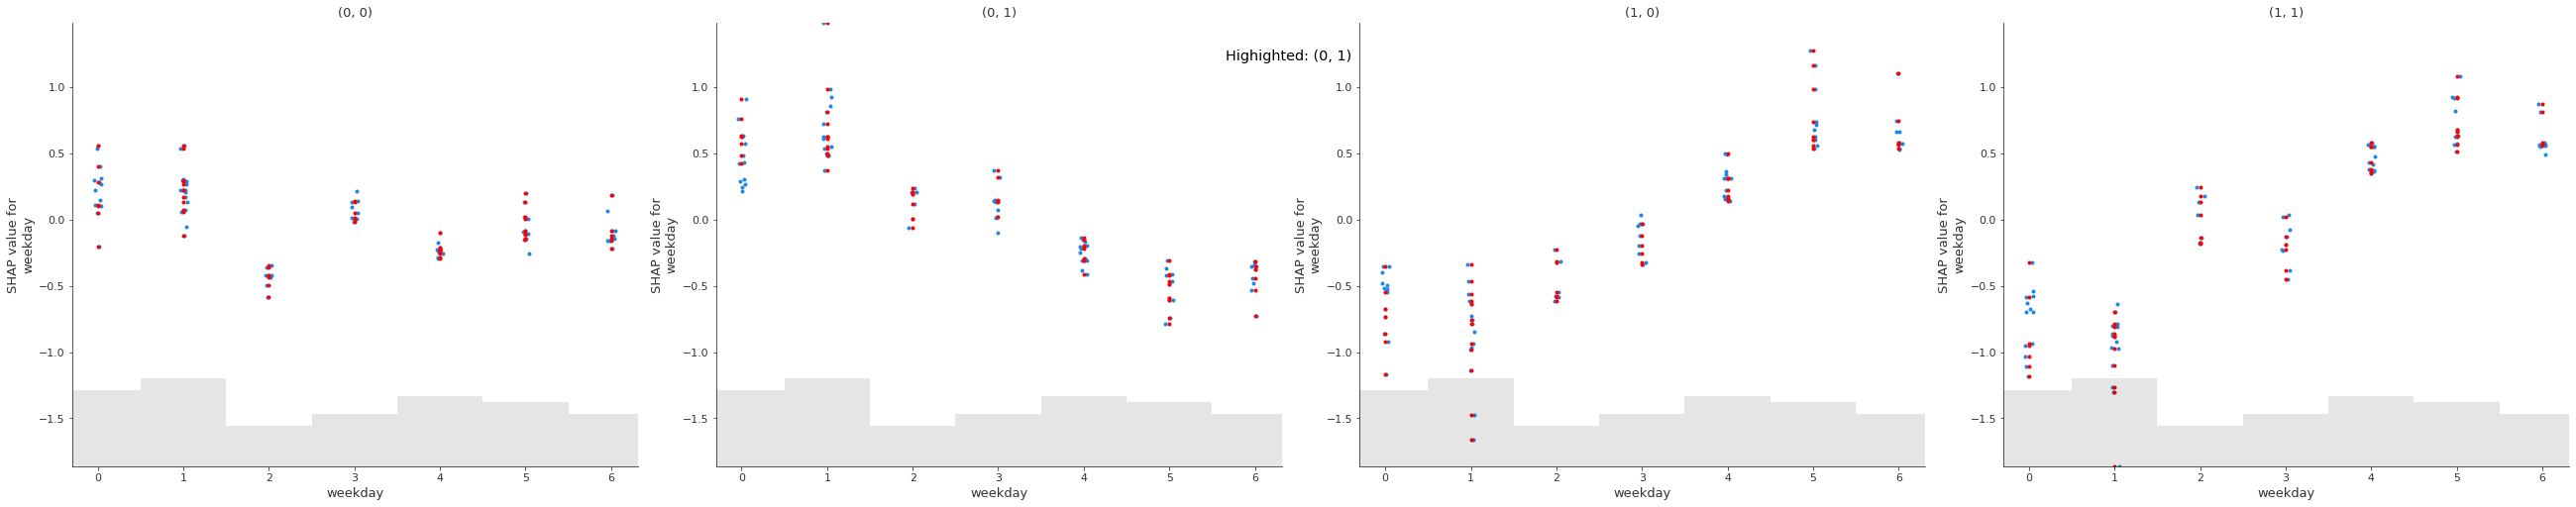

In [263]:
plot_feature('weekday')

In [265]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['weekday'] = 3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56,56


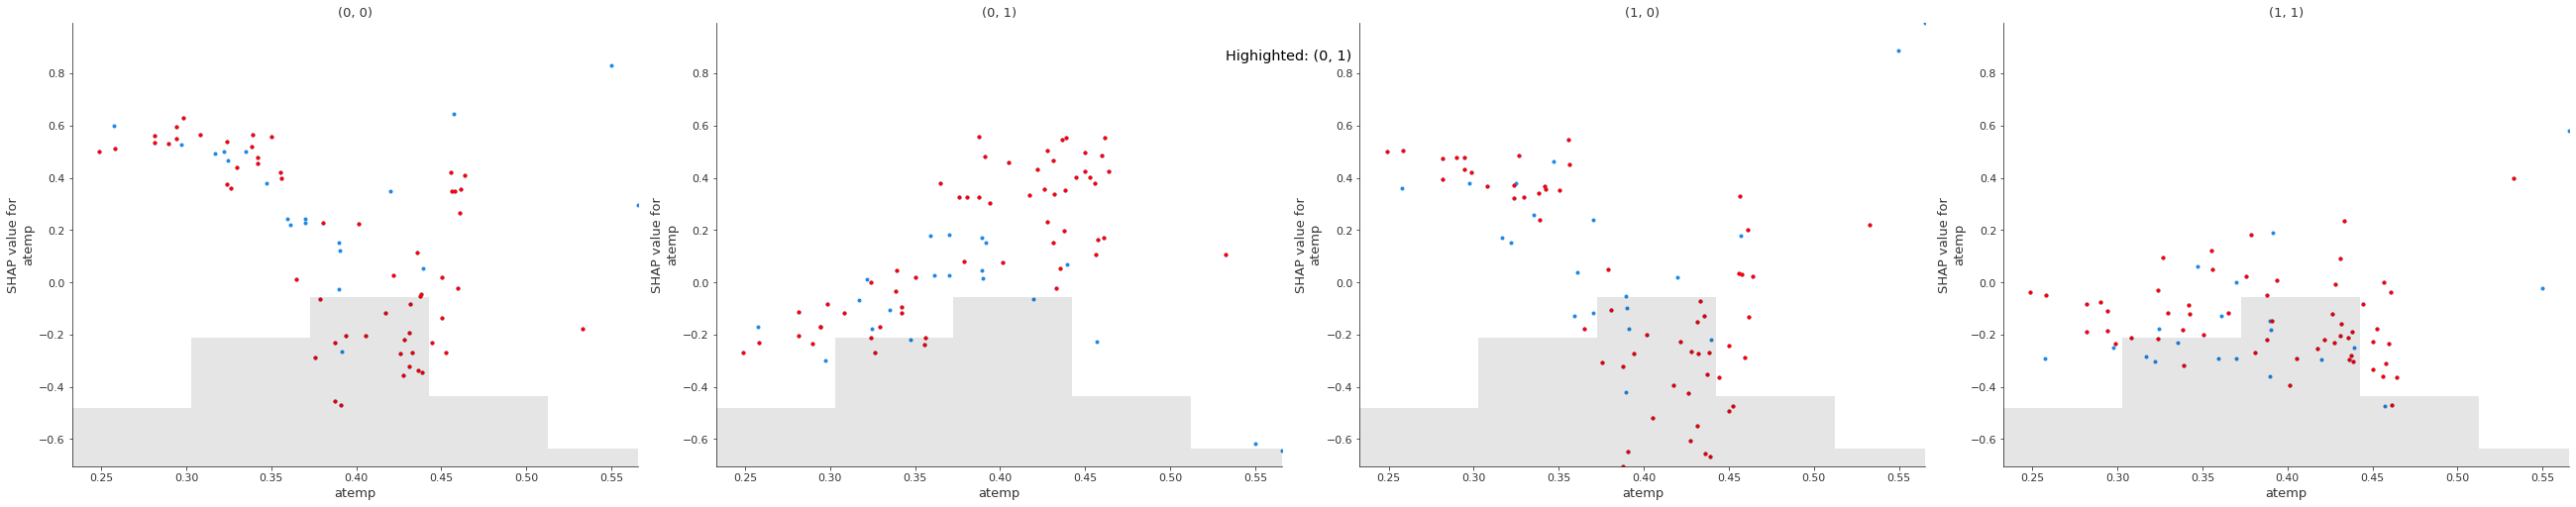

In [264]:
plot_feature('atemp')

In [266]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['atemp'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",56,56


In [267]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['hum'] = 0.9
X_test['mnth'] = 2
X_test['temp'] = 0.25
X_test['atemp'] = 0.3
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,53
"(0, 1)",56.0,3


if hum was relatively high (≥0.9), mnth was relatively low (≤2 (February)), temp was relatively low (≤0.25) and atemp was relatively low (≤0.3), both would predict the negative class

## Clustering of Class $(1,0)$ SHAP Values

In [196]:
diff_class = '(1, 0)'
shap_values = explanations.mclass_diff.log_odds[:, :, diff_class]
values = shap_values.values
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

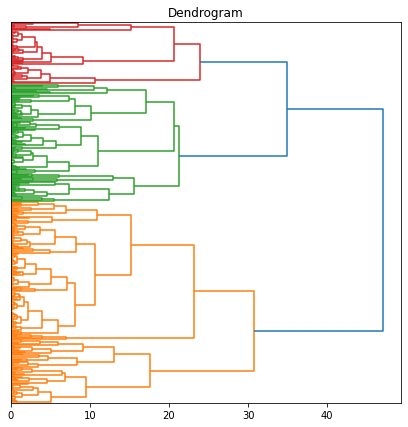

In [197]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [198]:
root = sp.cluster.hierarchy.to_tree(Z)
node = root
parent_nodes = []
traversed_nodes = []

In [199]:
node, shap_values, pred_classes = go_down(node, parent_nodes, traversed_nodes)

Level 1
(1, 1)    93
(0, 1)    69
(0, 0)    30
(1, 0)     2
dtype: int64


In [200]:
node, shap_values, pred_classes = go_down(node, parent_nodes, traversed_nodes)

Level 2
(0, 1)    30
(0, 0)    23
(1, 1)     6
(1, 0)     2
dtype: int64


In [201]:
node, shap_values, pred_classes = go_down(node, parent_nodes, traversed_nodes)

Level 3
(0, 1)    16
(0, 0)    14
(1, 1)     2
(1, 0)     2
dtype: int64


In [202]:
node, shap_values, pred_classes = go_down(node, parent_nodes, traversed_nodes)

Level 4
(0, 1)    15
(1, 1)     2
(0, 0)     1
dtype: int64


In [203]:
node, shap_values, pred_classes = get_next(node, parent_nodes, traversed_nodes)

Level 4
(0, 0)    13
(1, 0)     2
(0, 1)     1
dtype: int64


In [204]:
global_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.504081,6.513661,2.494536,0.612166,0.189572,1.368852,0.481852,2.986339,0.683060,0.030055
std,0.176112,3.455958,1.112185,0.134206,0.078194,0.516057,0.156756,2.006108,0.465921,0.170971
min,0.107500,1.000000,1.000000,0.254167,0.046650,1.000000,0.101658,0.000000,0.000000,0.000000
25%,0.347708,4.000000,2.000000,0.508125,0.133721,1.000000,0.350685,1.000000,0.000000,0.000000
50%,0.514167,7.000000,2.500000,0.611875,0.174750,1.000000,0.497779,3.000000,1.000000,0.000000
75%,0.653959,9.750000,3.000000,0.711146,0.231196,2.000000,0.607646,5.000000,1.000000,0.000000
max,0.861667,12.000000,4.000000,0.925000,0.441563,3.000000,0.804913,6.000000,1.000000,1.000000


In [205]:
local_data = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
local_data.iloc[:, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,16.000000,16.000000,16.000,16.000000,16.000000,16.0000,16.000000,16.000000,16.000,16.0000
mean,0.307507,11.562500,2.875,0.676526,0.132794,1.9375,0.313775,2.875000,0.625,0.0625
std,0.057093,0.727438,1.500,0.098089,0.033177,0.2500,0.056052,2.093641,0.500,0.2500
min,0.215833,10.000000,1.000,0.515417,0.059704,1.0000,0.223487,0.000000,0.000,0.0000
25%,0.253333,11.000000,1.000,0.587917,0.124382,2.0000,0.259328,1.000000,0.000,0.0000
50%,0.309583,12.000000,4.000,0.676459,0.137123,2.0000,0.319431,3.000000,1.000,0.0000
75%,0.350000,12.000000,4.000,0.755729,0.155940,2.0000,0.359681,4.250000,1.000,0.0000
max,0.415833,12.000000,4.000,0.823333,0.168726,2.0000,0.419813,6.000000,1.000,1.0000


In [206]:
local_data.iloc[pred_classes == diff_class, global_feature_order].describe()

,temp,mnth,season,hum,windspeed,weathersit,atemp,weekday,workingday,holiday
count,2.000000,2.0,2.0,2.000000,2.000000,2.0,2.000000,2.0,2.0,2.0
mean,0.343750,11.0,4.0,0.601042,0.155167,2.0,0.347217,4.0,1.0,0.0
std,0.031230,0.0,0.0,0.027400,0.003082,0.0,0.032138,0.0,0.0,0.0
min,0.321667,11.0,4.0,0.581667,0.152987,2.0,0.324492,4.0,1.0,0.0
25%,0.332708,11.0,4.0,0.591355,0.154077,2.0,0.335855,4.0,1.0,0.0
50%,0.343750,11.0,4.0,0.601042,0.155167,2.0,0.347217,4.0,1.0,0.0
75%,0.354792,11.0,4.0,0.610730,0.156256,2.0,0.358579,4.0,1.0,0.0
max,0.365833,11.0,4.0,0.620417,0.157346,2.0,0.369942,4.0,1.0,0.0


- $0.21 < temp < 0.42$
- $10 ≤ mnth$
- $season == 1 \lor season == 4$
- $hum < 0.17$
- $0.22 < atemp < 0.42$

In [207]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 0)",2.0,NaN
"(1, 1)",NaN,2.0


B concludes with A on the positive class for a higher temp value of 0.5 in all 2 cases.

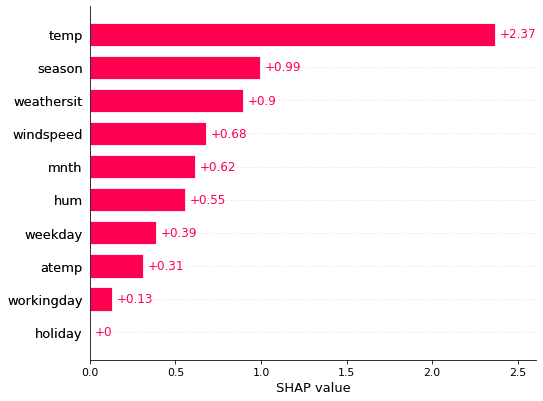

In [208]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, np.unique(pred_classes)])
plot_feature_importance_bar(feature_importances)

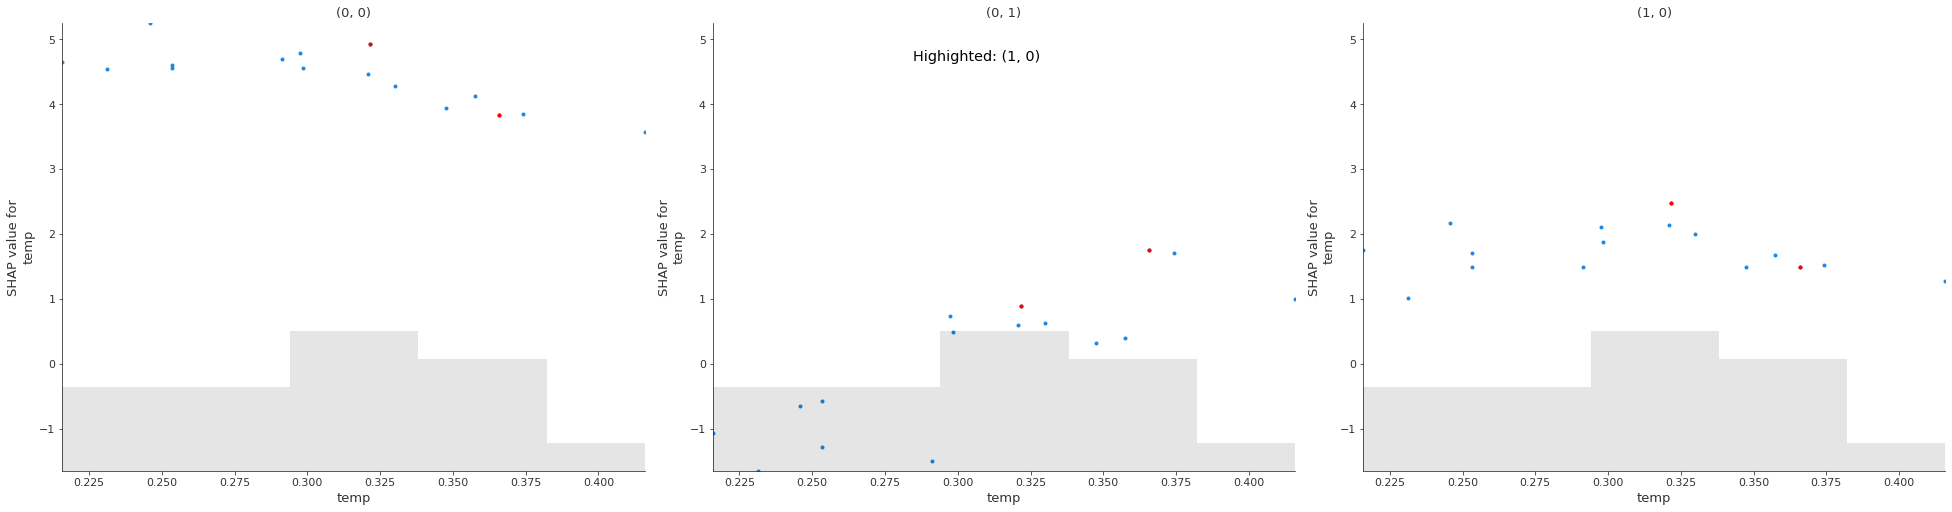

In [209]:
plot_feature('temp')

In [210]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['temp'] = 0.225
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(1, 0)",2,2


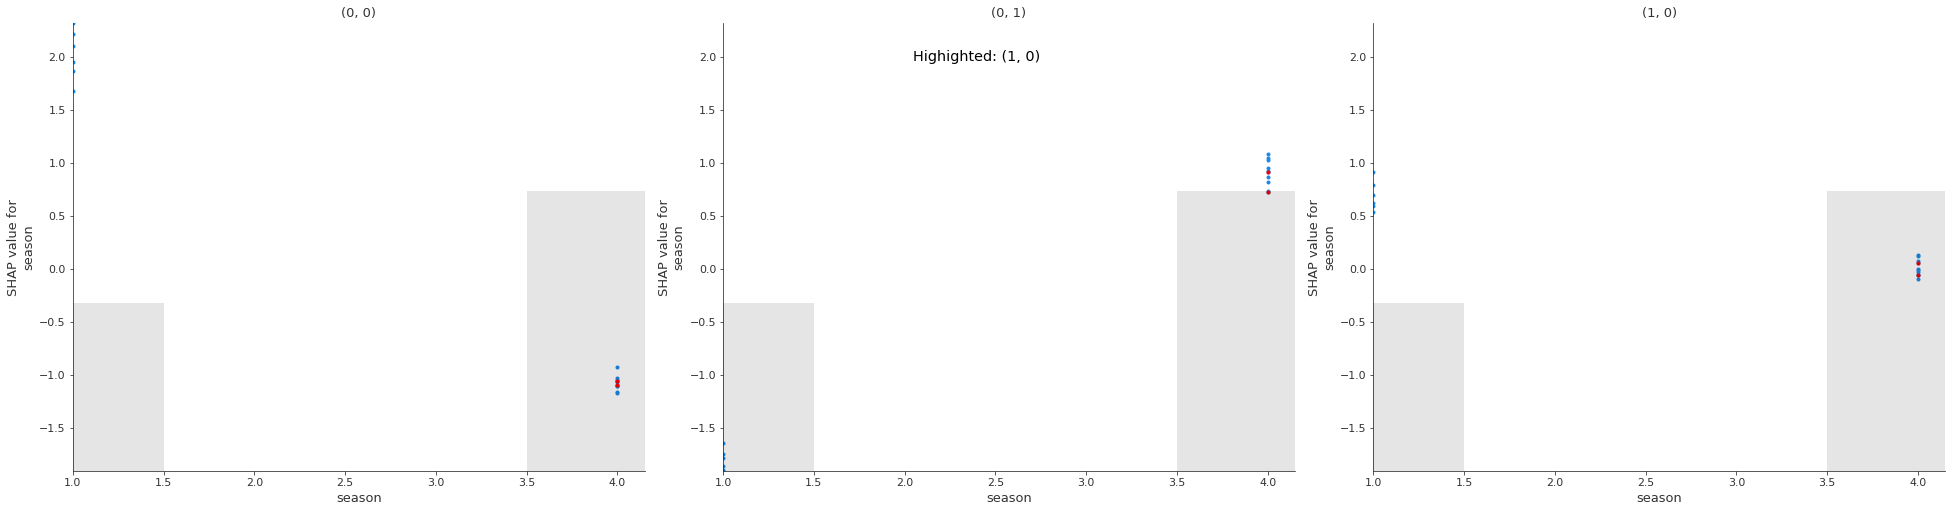

In [211]:
plot_feature('season')

In [212]:
X_test = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
X_test['season'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X_test)])
mask = pred_classes == diff_class
display(pd.DataFrame({'before': y_before[mask].value_counts(),
                      'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,2.0
"(1, 0)",2.0,NaN


A starts to predict the positive class earlier than B above a relatively low season of 1 in all 2 cases.